# Introduction

PowerCo is a major gas and electricity company concerned about losing customers. We have been been provided with the client data and price data and we will try to determine what the major drivers of churn are.

Our leading hypothesis is: 'Does price sensitivity affect churn?'

# Exploratory Data Analysis

## Import Necessary Packages

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

# pip install optuna

import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
import lightgbm as lgb

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, fbeta_score

---

## Loading data

We need to load `client_data.csv` and `price_data.csv` into dataframes.

**client_data.csv**
* id = client company identifier
* activity_new = category of the company’s activity
* channel_sales = code of the sales channel
* cons_12m = electricity consumption of the past 12 months
* cons_gas_12m = gas consumption of the past 12 months
* cons_last_month = electricity consumption of the last month
* date_activ = date of activation of the contract
* date_end = registered date of the end of the contract
* date_modif_prod = date of the last modification of the product
* date_renewal = date of the next contract renewal
* forecast_cons_12m = forecasted electricity consumption for next 12 months
* forecast_cons_year = forecasted electricity consumption for the next calendar year
* forecast_discount_energy = forecasted value of current discount
* forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
* forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
* forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
* forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
* has_gas = indicated if client is also a gas client
* imp_cons = current paid consumption
* margin_gross_pow_ele = gross margin on power subscription
* margin_net_pow_ele = net margin on power subscription
* nb_prod_act = number of active products and services
* net_margin = total net margin
* num_years_antig = antiquity of the client (in number of years)
* origin_up = code of the electricity campaign the customer first subscribed to
* pow_max = subscribed power
* churn = has the client churned over the next 3 months

**price_data.csv**
* id = client company identifier
* price_date = reference date
* price_off_peak_var = price of energy for the 1st period (off peak)
* price_peak_var = price of energy for the 2nd period (peak)
* price_mid_peak_var = price of energy for the 3rd period (mid peak)
* price_off_peak_fix = price of power for the 1st period (off peak)
* price_peak_fix = price of power for the 2nd period (peak)
* price_mid_peak_fix = price of power for the 3rd period (mid peak)

In [2]:
client_df = pd.read_csv('client_data.csv')
price_df = pd.read_csv('price_data.csv')

In [3]:
client_df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0         0         54946                0  2013-06-15  2016-06-15   
1      4660             0                0  2009-08-21  2016-08-30   
2       544             0                0  2010-04-16  2016-04-16   
3      1584             0                0  2010-03-30  2016-03-30   
4      4425             0              526  2010-01-13  2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  has_gas  imp_cons  \
0      2015-11-01   2015-06-23               0.00  ...        t      0.00   
1      2009-08-21   2015-08-31             189.95  ...        f      0.00   
2      2010-04-16   2015-04-17              47.96  ...        f      0.00   
3      2010-03-30   2015-03-31             240.04  ...        f      0.00   
4      2010-01-13   2015-03-09             445.75  ...        f     52.32   

   margin_gross_pow_ele  margin_net_pow_ele  nb_prod_act  net_margin  \
0                 25.44               25.44            2      678.99   
1                 16.38               16.38            1       18.89   
2                 28.60               28.60            1        6.60   
3                 30.22               30.22            1       25.46   
4                 44.91               44.91            1       47.98   

  num_years_antig                         origin_up  pow_max  churn  
0               3  lxidpiddsbxsbosboudacockeimpuepw   43.648      1  
1               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.800      0  
2               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.856      0  
3               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.200      0  
4               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   19.800      0  

[5 rows x 26 columns]

In [4]:
price_df.head()

id  price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745  2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745  2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745  2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745  2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745  2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

---

## Descriptive statistics of data

### Data types

To get an overview of the data types within a data frame, we will use the `info()` method.

In [5]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

The client data has a mix of data types which may need to be transformed later on.

In [6]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


The price data looks to be all numeric but there are a lot of 0 values that need to be looked into later on.

### Statistics

Now let's look at some statistics about the datasets. We can do this by using the `describe()` method.

In [7]:
client_df.describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.795000   
75%           1745.750000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak      imp_cons  margin_gross_pow_ele  \
count                 14606.000000  14606.000000          14606.000000   
mean                     43.130056    152.786896             24.565121   
std                       4.485988    341.369366             20.231172   
min                       0.000000      0.000000              0.000000   
25%                      40.606701      0.000000             14.280000   
50%                      44.311378     37.395000             21.640000   
75%                      44.311378    193.980000             29.880000   
max                      59.266378  15042.790000            374.640000   

       margin_net_pow_ele   nb_prod_act    net_margin  num_years_antig  \
count        14606.000000  14606.000000  14606.000000     14606.000000   
mean            24.562517      1.292346    189.264522         4.997809   
std             20.230280      0.709774    311.798130         1.611749   
min              0.000000      1.000000      0.000000         1.000000   
25%             14.280000      1.000000     50.712500         4.000000   
50%             21.640000      1.000000    112.530000         5.000000   
75%             29.880000      1.000000    243.097500         6.000000   
max            374.640000     32.000000  24570.650000        13.000000   

            pow_max         churn  
count  14606.000000  14606.000000  
mean      18.135136      0.097152  
std       13.534743      0.296175  
min        3.300000      0.000000  
25%       12.500000      0.000000  
50%       13.856000      0.000000  
75%       19.172500      0.000000  
max      320.000000      1.000000

In [8]:
client_df.describe(include=object)

id                     channel_sales  \
count                              14606                             14606   
unique                             14606                                 8   
top     563dde550fd624d7352f3de77c0cdfcd  foosdfpfkusacimwkcsosbicdxkicaua   
freq                                   1                              6754   

        date_activ    date_end date_modif_prod date_renewal has_gas  \
count        14606       14606           14606        14606   14606   
unique        1796         368            2129          386       2   
top     2009-08-01  2016-02-01      2015-11-01   2015-06-23       f   
freq            95         145             721          587   11955   

                               origin_up  
count                              14606  
unique                                 6  
top     lxidpiddsbxsbosboudacockeimpuepw  
freq                                7097

In [9]:
price_df.describe()

price_off_peak_var  price_peak_var  price_mid_peak_var  \
count       193002.000000   193002.000000       193002.000000   
mean             0.141027        0.054630            0.030496   
std              0.025032        0.049924            0.036298   
min              0.000000        0.000000            0.000000   
25%              0.125976        0.000000            0.000000   
50%              0.146033        0.085483            0.000000   
75%              0.151635        0.101673            0.072558   
max              0.280700        0.229788            0.114102   

       price_off_peak_fix  price_peak_fix  price_mid_peak_fix  
count       193002.000000   193002.000000       193002.000000  
mean            43.334477       10.622875            6.409984  
std              5.410297       12.841895            7.773592  
min              0.000000        0.000000            0.000000  
25%             40.728885        0.000000            0.000000  
50%             44.266930        0.000000            0.000000  
75%             44.444710       24.339581           16.226389  
max             59.444710       36.490692           17.458221

The key takeaway at this point is that the client data has a lot of highly skewed features like 'cons_gas_12m', 'cons_12m' and more

---

## Data visualization

Below are some functions to get started with visualizations.

In [10]:
def plot_stacked_bars(dataframe, title_, size_=(16, 8), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:

        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

Having defined the functions, we will then proceed to visualize the data

### Churn

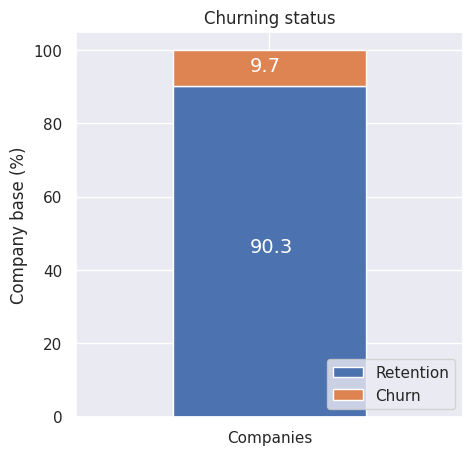

In [11]:
churn = client_df[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

### Sales Channel

In [12]:
sales_channel = client_df[['id', 'channel_sales', 'churn']].groupby(['channel_sales', 'churn']).count().unstack().fillna(0)
sales_channel_stack = (sales_channel.div(sales_channel.sum(axis=1), axis=0)*100).sort_values(by=('id', 1), ascending=False)

In [13]:
sales_channel

id       
churn                                  0      1
channel_sales                                  
MISSING                           3442.0  283.0
epumfxlbckeskwekxbiuasklxalciiuu     3.0    0.0
ewpakwlliwisiwduibdlfmalxowmwpci   818.0   75.0
fixdbufsefwooaasfcxdxadsiekoceaa     2.0    0.0
foosdfpfkusacimwkcsosbicdxkicaua  5934.0  820.0
lmkebamcaaclubfxadlmueccxoimlema  1740.0  103.0
sddiedcslfslkckwlfkdpoeeailfpeds    11.0    0.0
usilxuppasemubllopkaafesmlibmsdf  1237.0  138.0

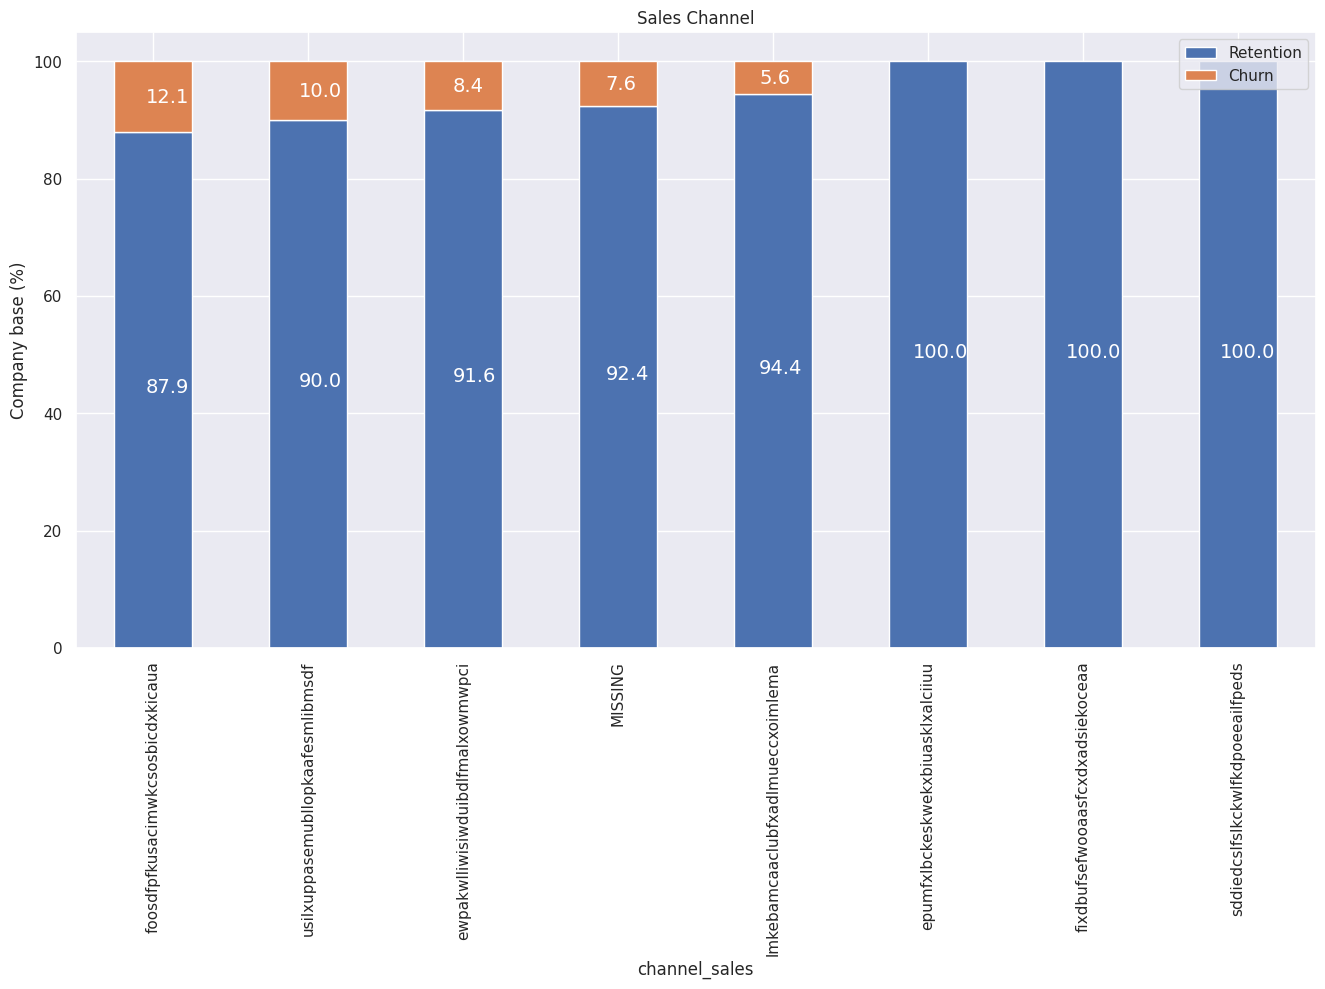

In [14]:
plot_stacked_bars(sales_channel_stack, 'Sales Channel', rot_=90)

Churn only occurs over 5 of the 8 sales channels. We can also see from the table that the 3 channels without churn account for the lowest number of clients

### Has both Gas and Electric

Visualizing the distribution of the categorical variables as well

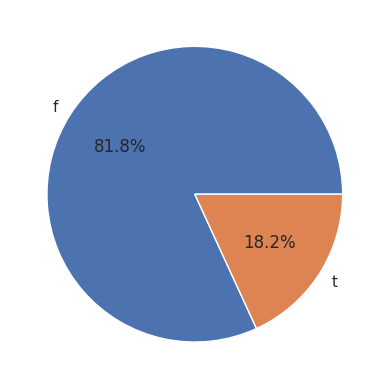

In [15]:
plt.pie(client_df['has_gas'].value_counts(), labels=client_df['has_gas'].value_counts().index, autopct='%1.1f%%')
plt.show()

81% of the clients had only electricity while 18% had both electricity and gas provided to them

In [16]:
# Creating a little table showing Clients grouped by churn and has_gas and represented as a percentage
has_gas = client_df[['id', 'churn','has_gas']]
has_gas.columns = ['Client', 'churn', 'has_gas']
has_gas_total= has_gas.groupby(['has_gas', 'churn']).count()
has_gas_percentage = has_gas_total / has_gas_total.groupby(level=0).sum() * 100
has_gas_percentage.reset_index(inplace=True)

has_gas_percentage.replace({'f':'No', 't':'Yes'}, inplace=True)

In [17]:
has_gas_percentage

has_gas  churn     Client
0      No      0  89.945629
1      No      1  10.054371
2     Yes      0  91.814410
3     Yes      1   8.185590

In [18]:
# Creating stacked bar chart with altair
import altair as alt

# Create the stacked bar chart
alt.Chart(has_gas_percentage).mark_bar().encode(
    x='has_gas',
    y='Client',
    color='churn'
).properties(title='Stacked Bar Chart of Clients by Gas and Churn')


alt.Chart(...)

Out of the 2 subsets of cutomers - with gas and without gas - while there was a similar percentage of churn, customers with only 1 product from PowerCo, electricity are 2% more likely to churn than customers with both gas and electric.

### Consumption

Let's see the distribution of the consumption in the last month and the last year

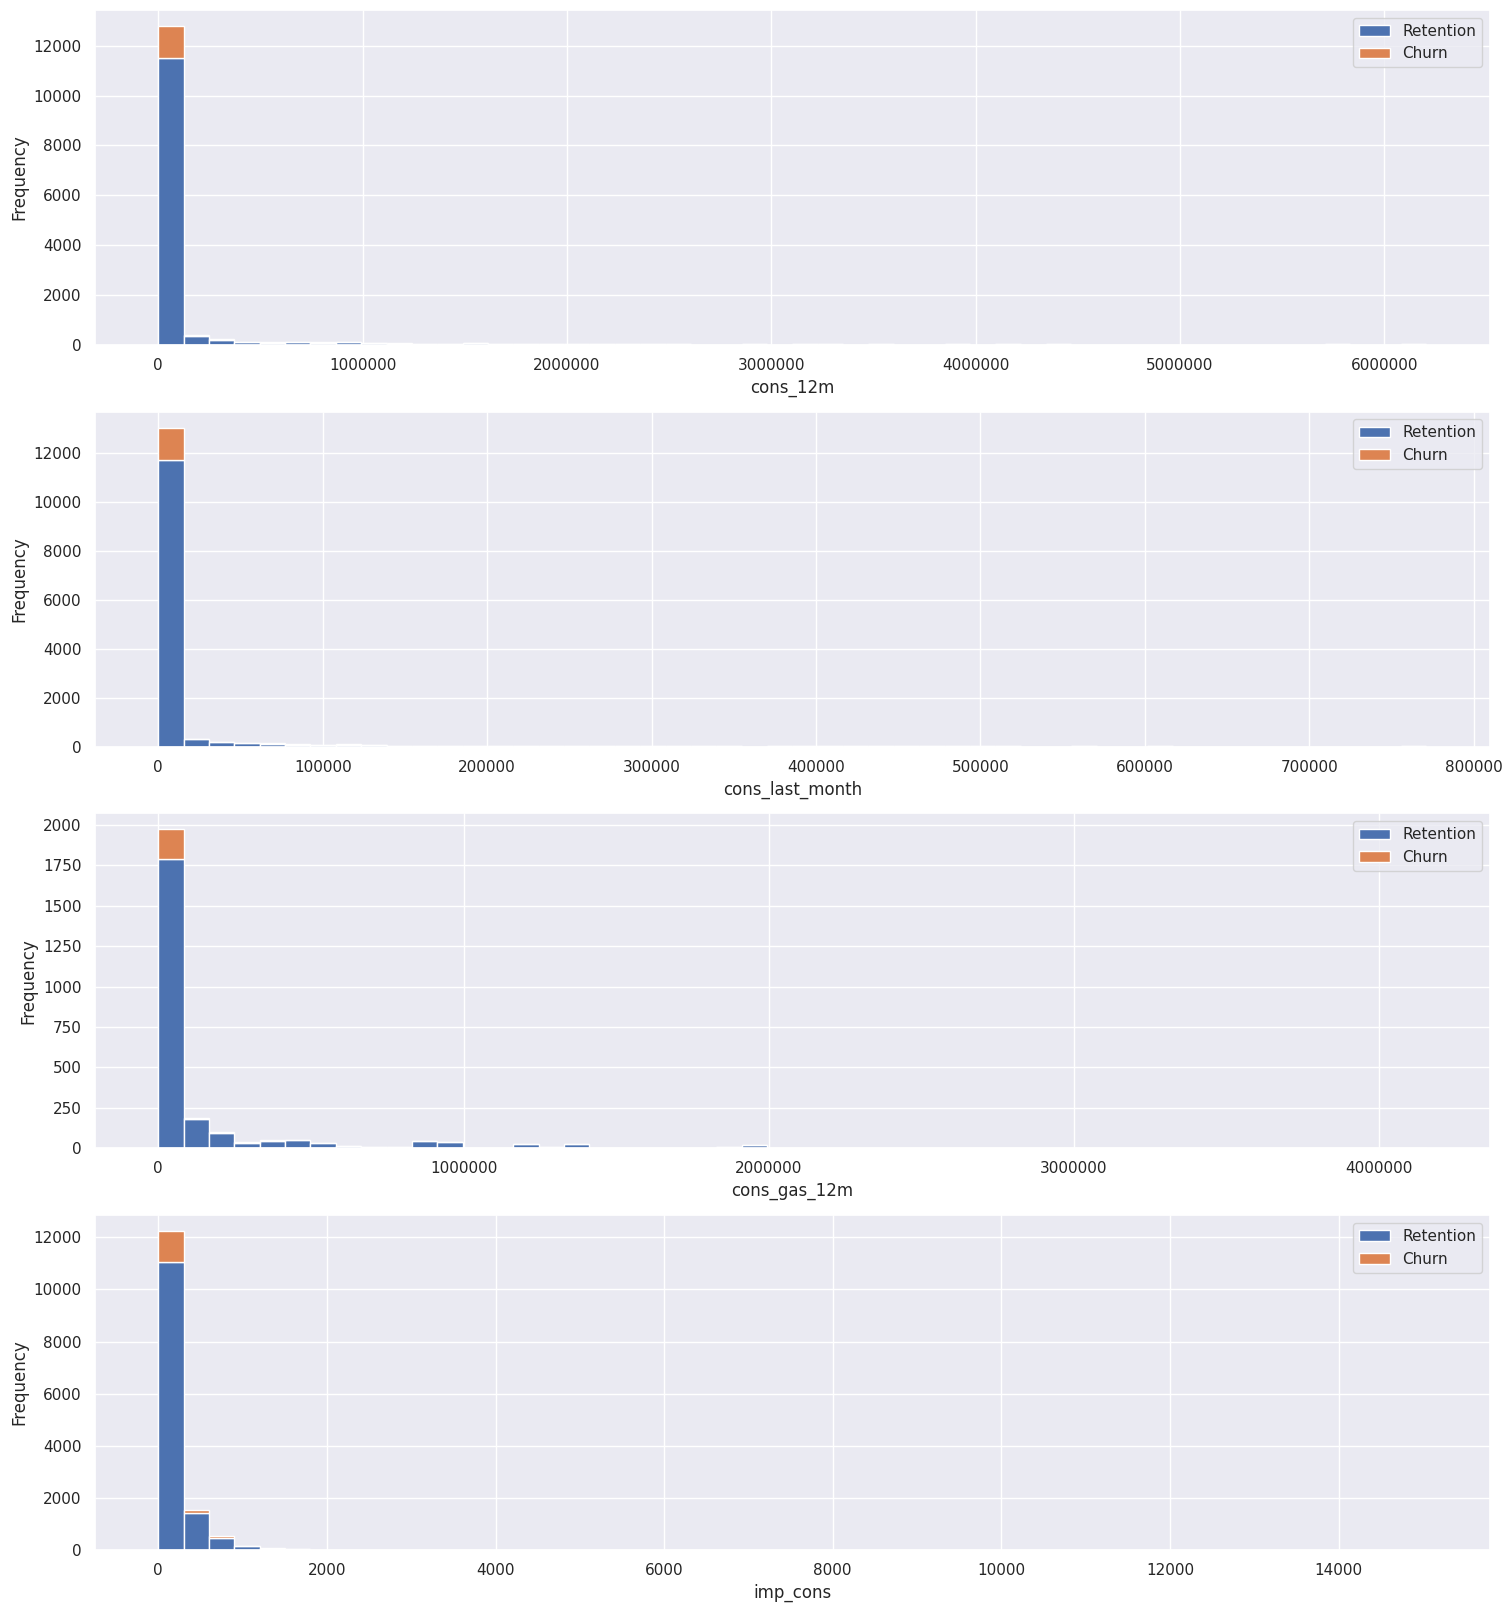

In [19]:
fig, axs = plt.subplots(nrows=4, figsize=(18, 20))

plot_distribution(client_df, 'cons_12m', axs[0])
plot_distribution(client_df, 'cons_last_month', axs[1])
plot_distribution(client_df[client_df['has_gas']=='t'], 'cons_gas_12m', axs[2])
plot_distribution(client_df, 'imp_cons', axs[3])

We can see that the consumption data is heavily skewed so we will use a boxplot to visualize the outliers

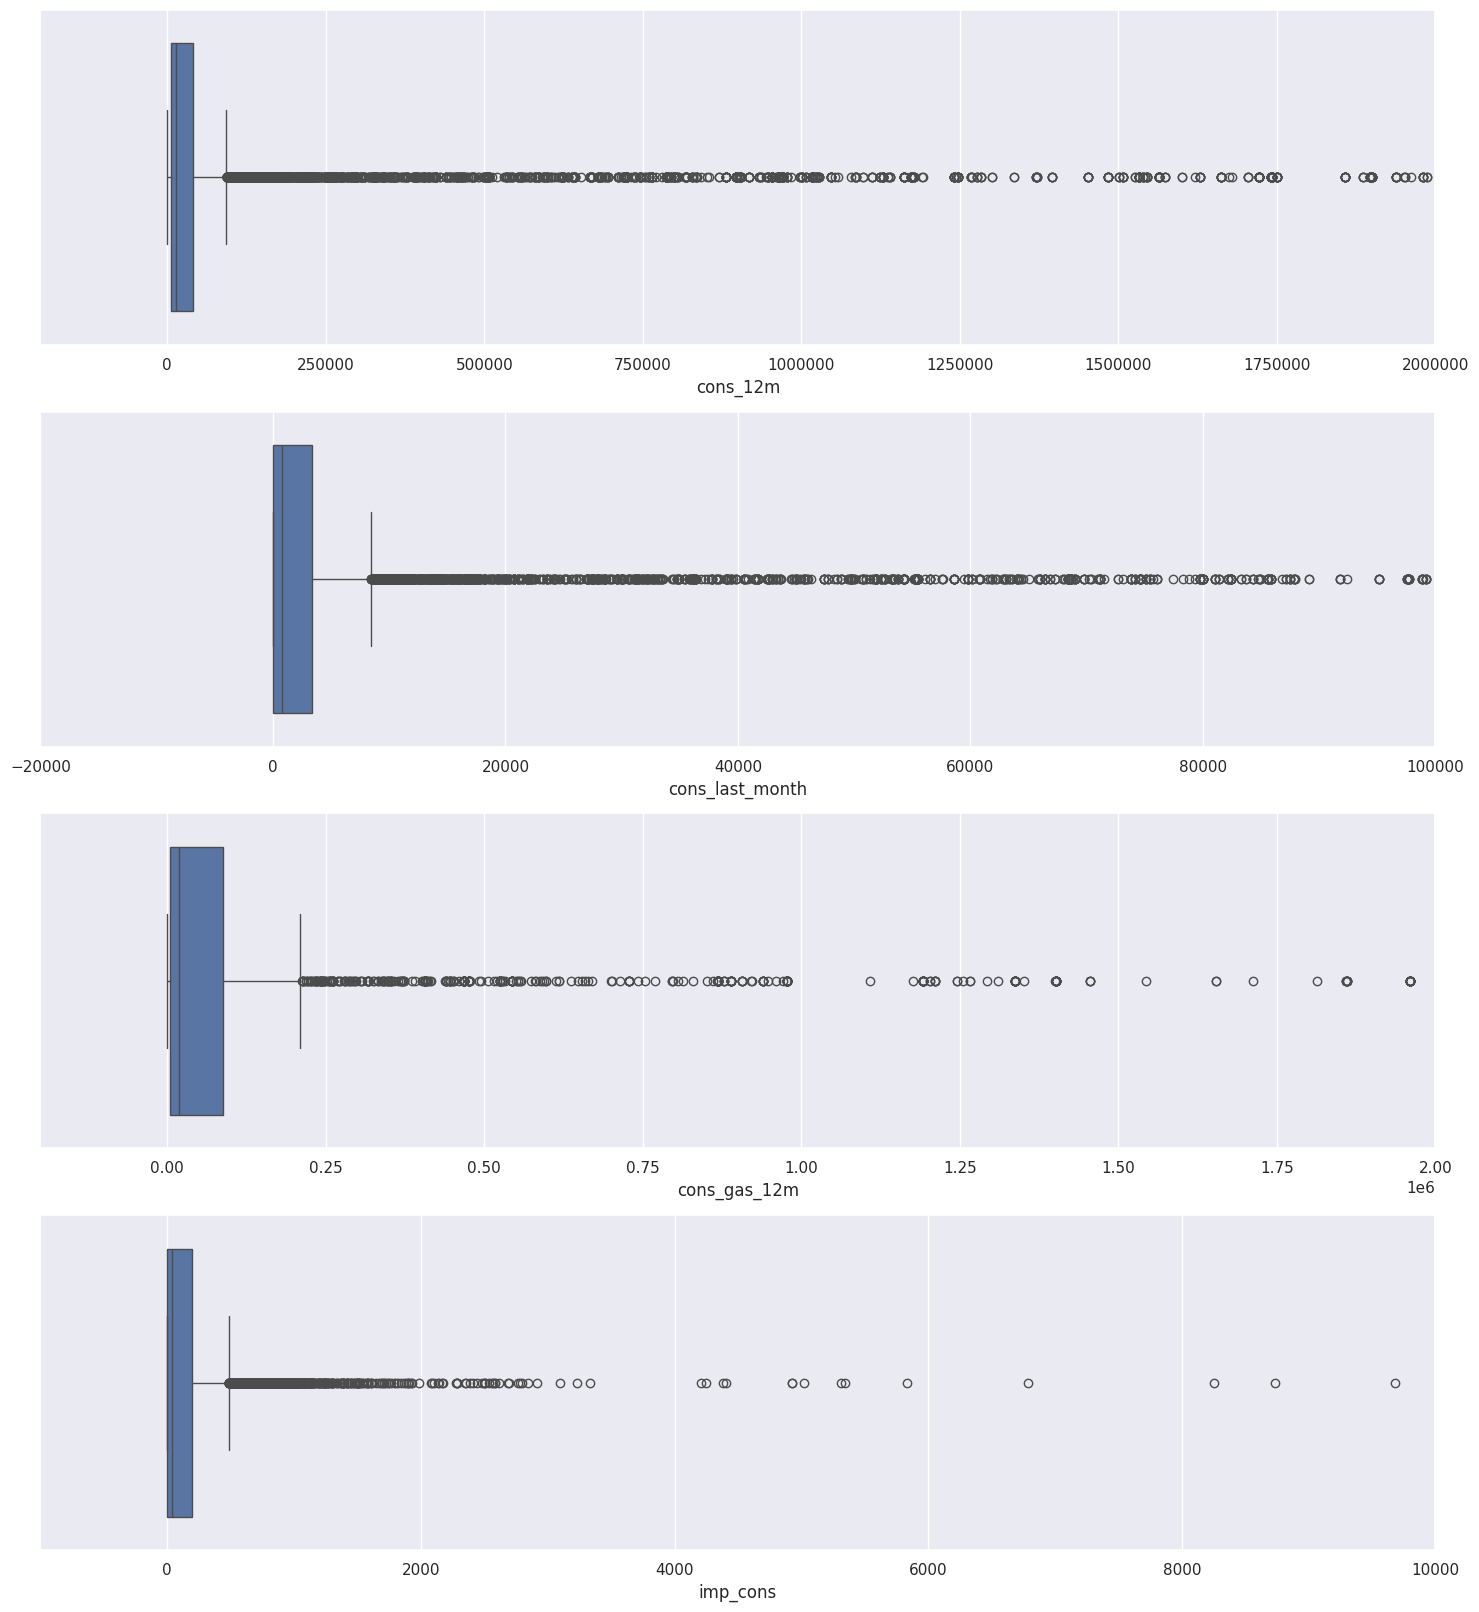

In [20]:
fig, axs = plt.subplots(nrows=4, figsize=(18, 20))

sns.boxplot(x=client_df['cons_12m'], ax=axs[0])
sns.boxplot(x=client_df['cons_last_month'], ax=axs[1])
sns.boxplot(x=client_df[client_df['has_gas']=='t']['cons_gas_12m'], ax=axs[2])
sns.boxplot(x=client_df['imp_cons'], ax=axs[3])

for ax in axs:
    ax.ticklabel_format(style='plain', axis='x')
    axs[0].set_xlim(-200000, 2000000)
    axs[1].set_xlim(-20000, 100000)
    axs[2].set_xlim(-200000, 2000000)
    axs[3].set_xlim(-1000, 10000)
    plt.show()

### Forecasted features

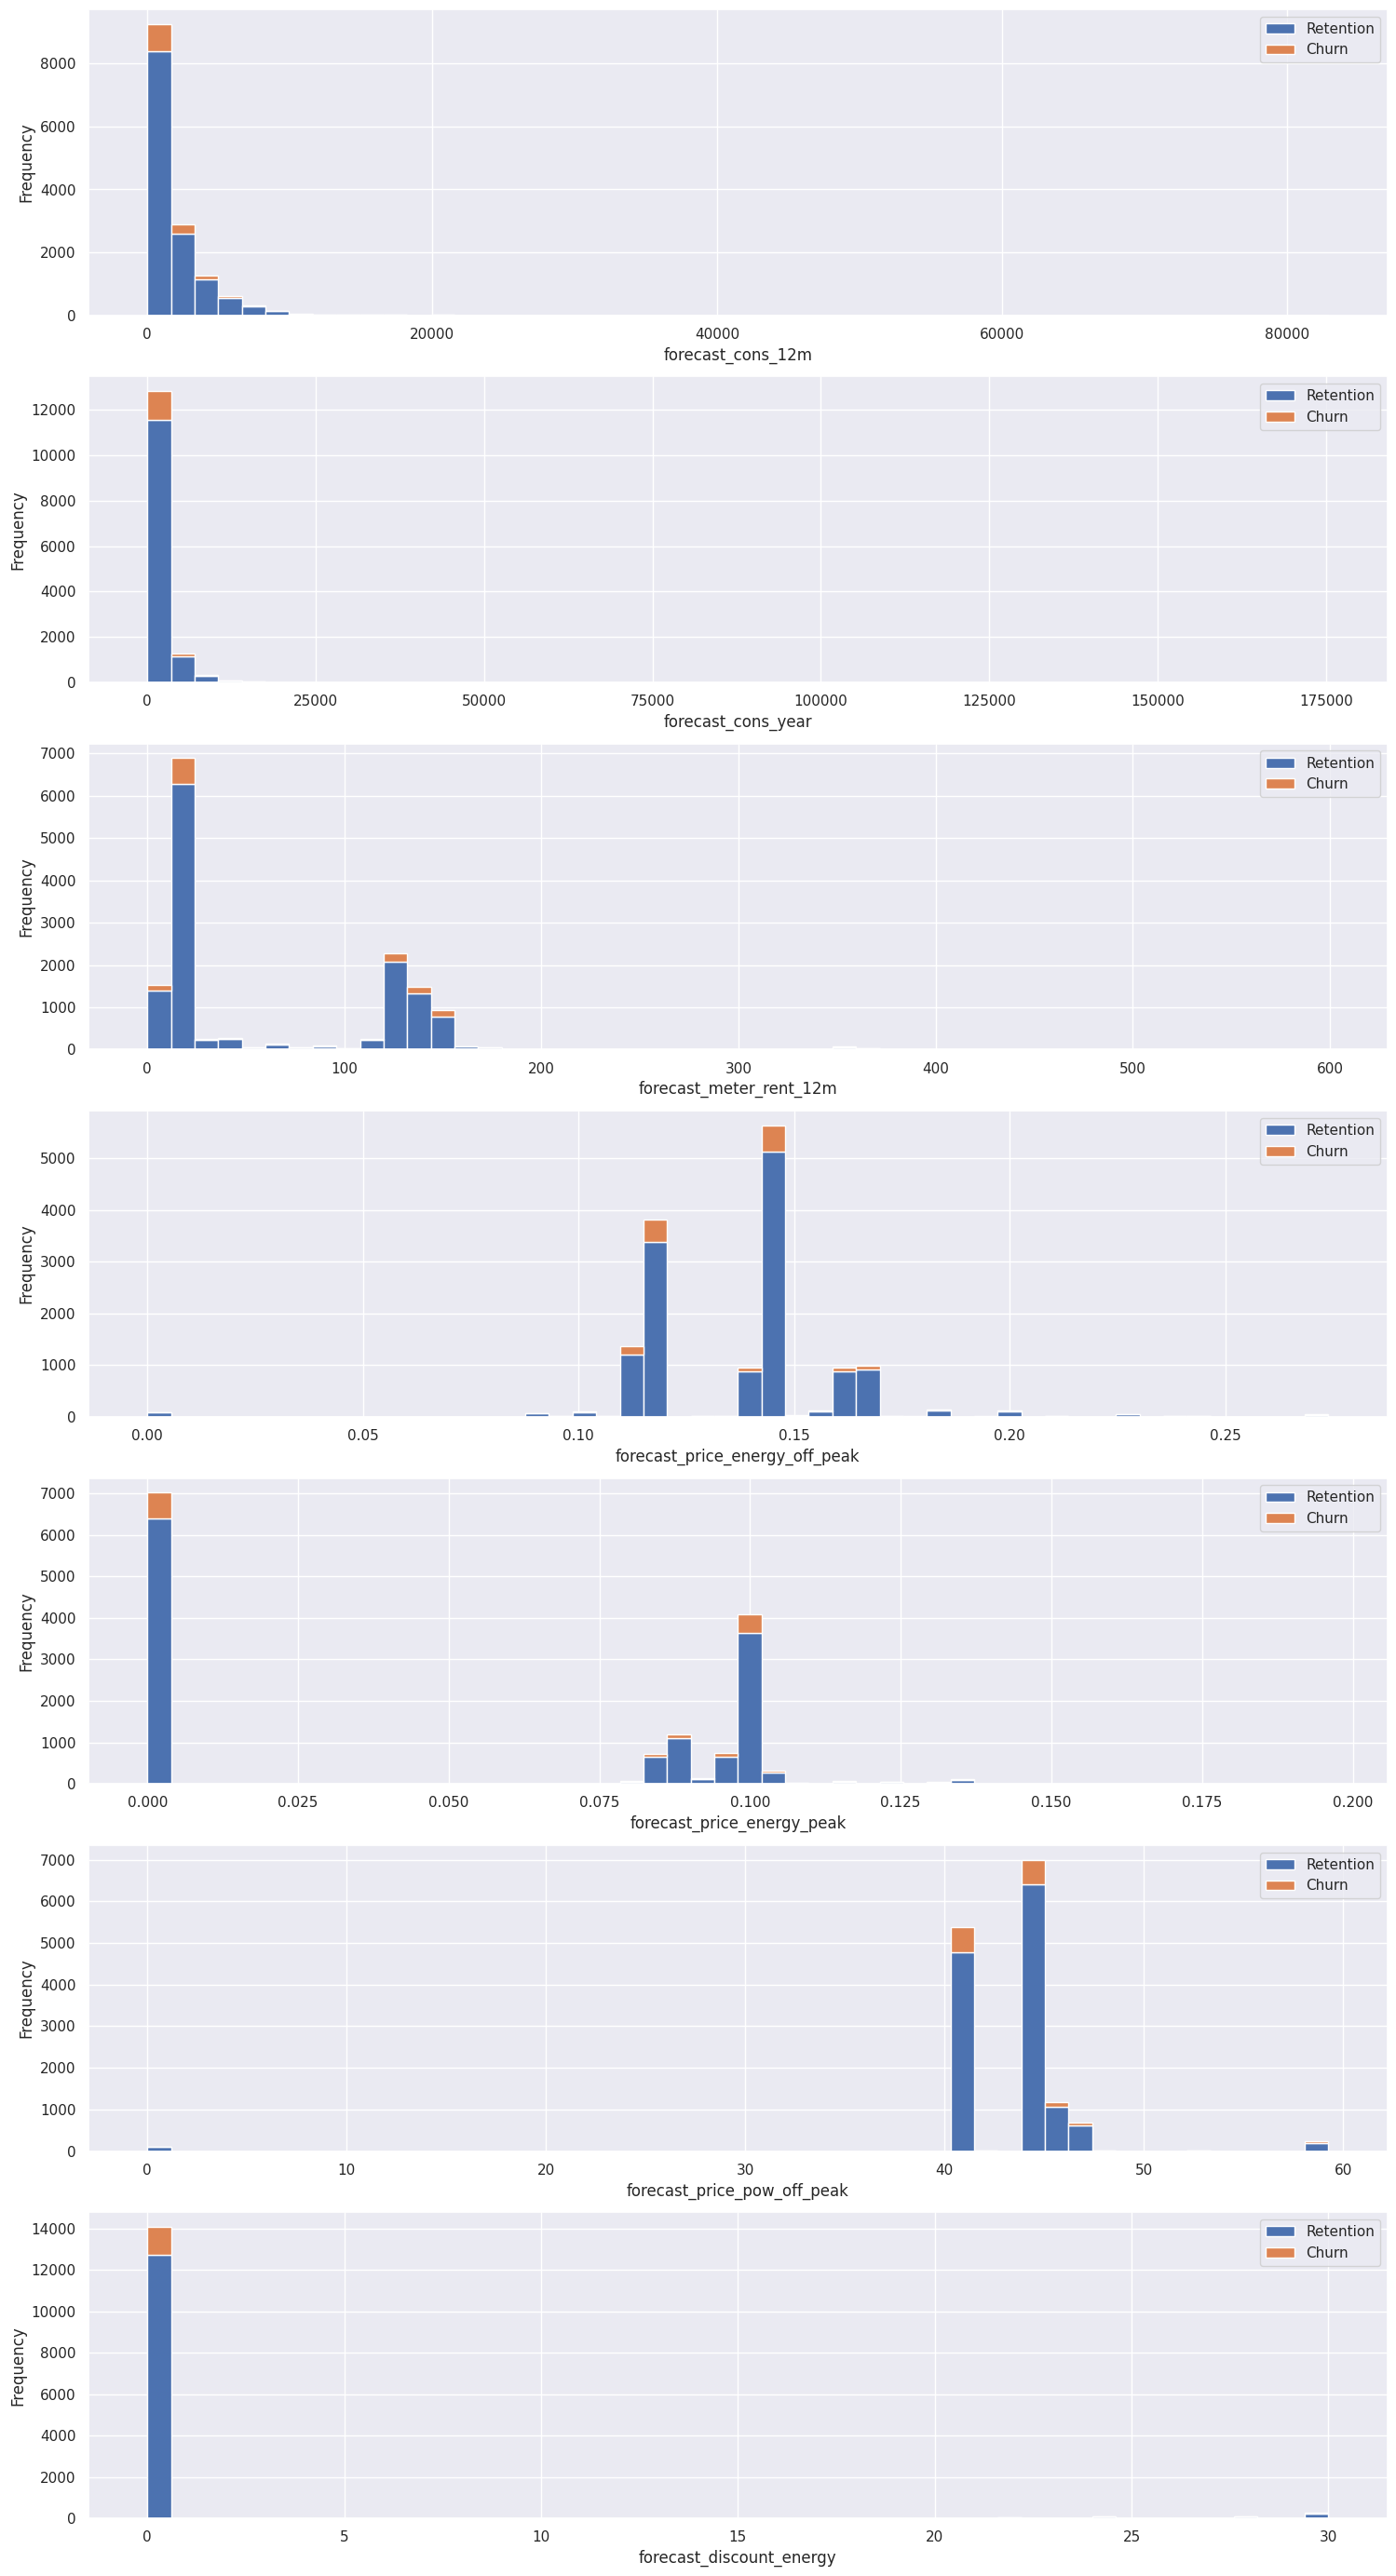

In [21]:
fig, axs = plt.subplots(nrows=7, figsize=(18, 35))

plot_distribution(client_df, 'forecast_cons_12m', axs[0])
plot_distribution(client_df, 'forecast_cons_year', axs[1])
plot_distribution(client_df, 'forecast_meter_rent_12m', axs[2])
plot_distribution(client_df, 'forecast_price_energy_off_peak', axs[3])
plot_distribution(client_df, 'forecast_price_energy_peak', axs[4])
plot_distribution(client_df, 'forecast_price_pow_off_peak', axs[5])
plot_distribution(client_df, 'forecast_discount_energy', axs[6])

Like the consumption features, a lot of the forecast features are highly skewed as well. To be corrected during feature engineering.

### Margins

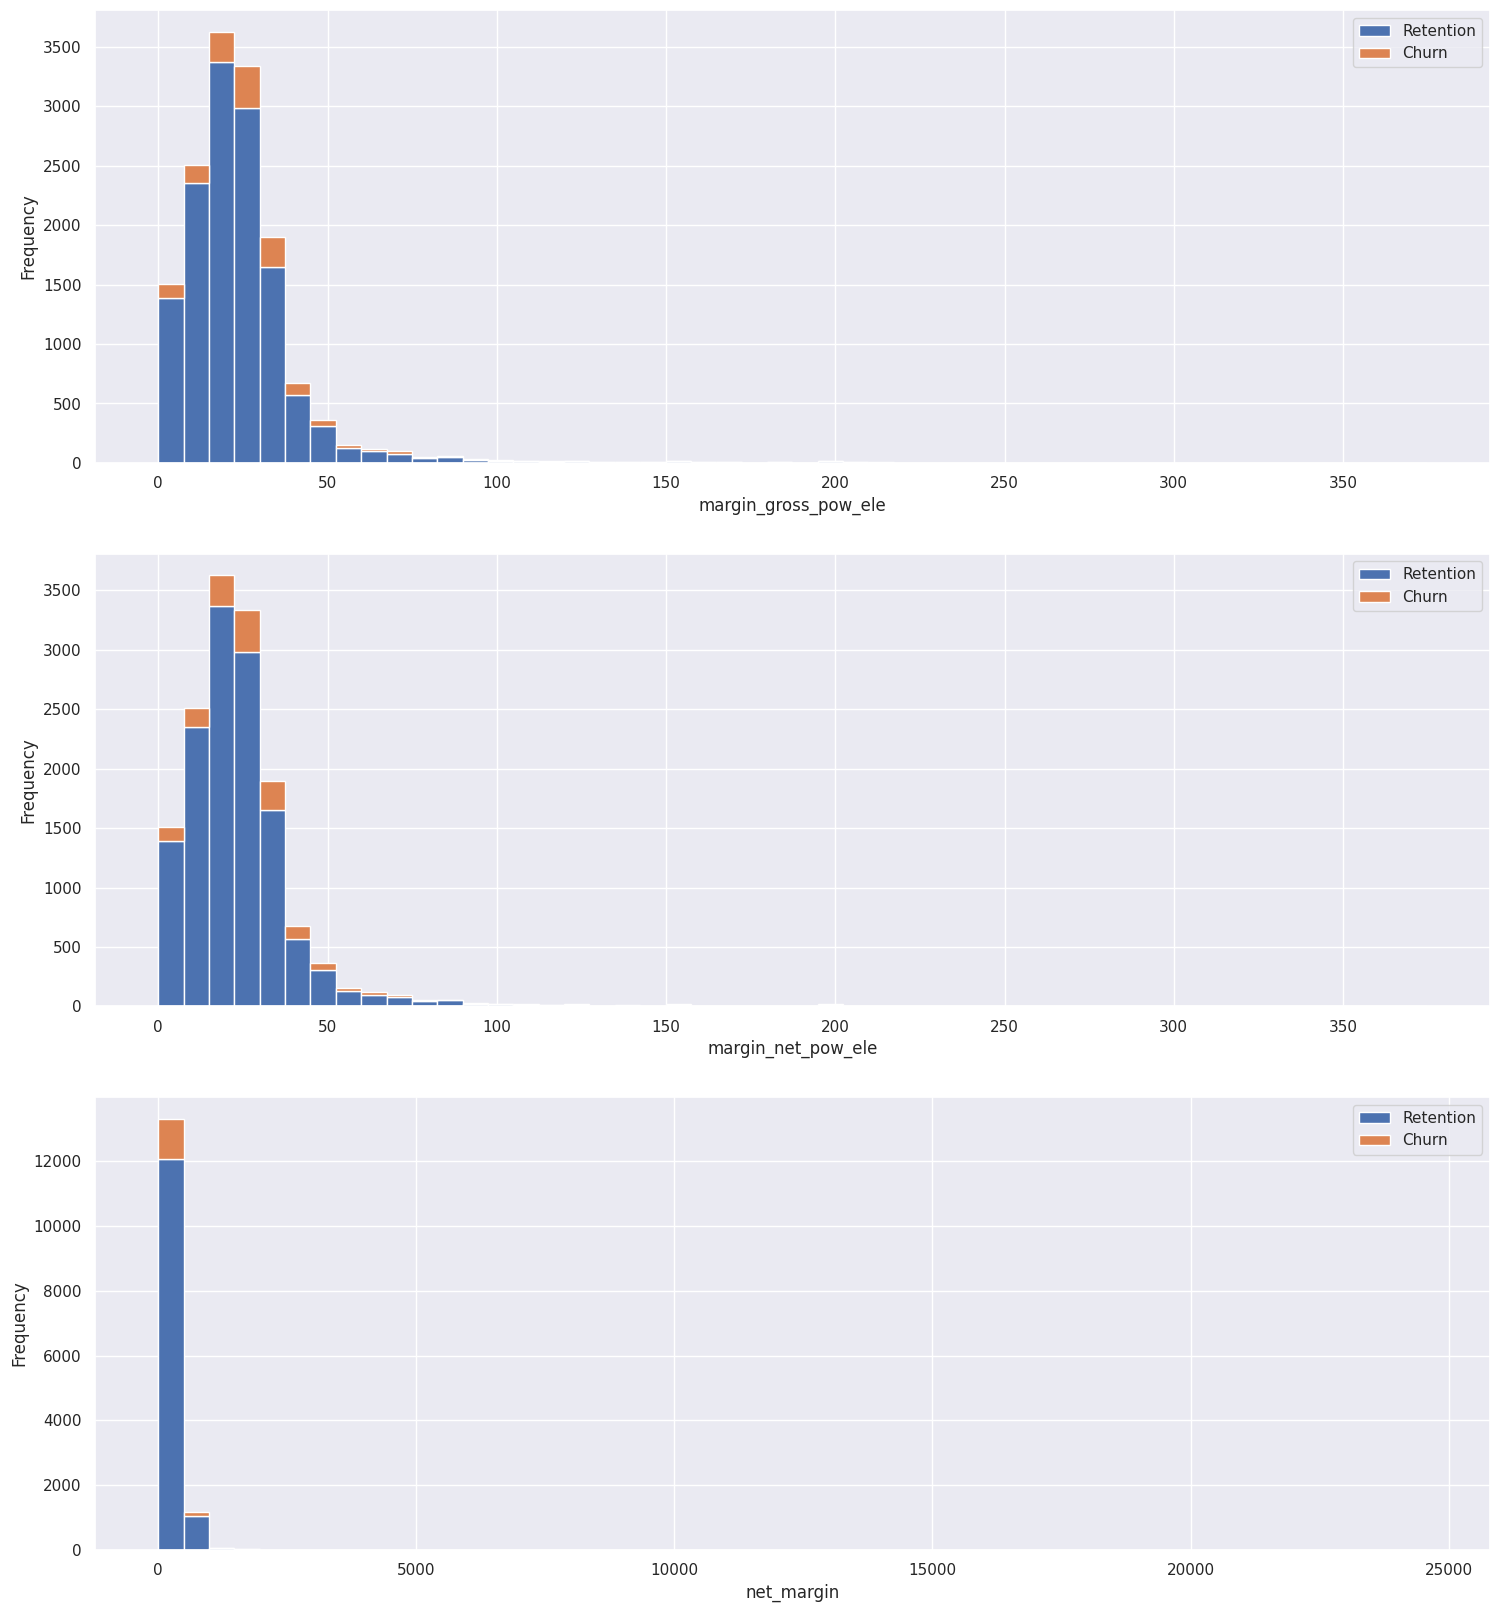

In [22]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))

plot_distribution(client_df, 'margin_gross_pow_ele', axs[0])
plot_distribution(client_df, 'margin_net_pow_ele', axs[1])
plot_distribution(client_df, 'net_margin', axs[2])

We have outliers present in the margins as well

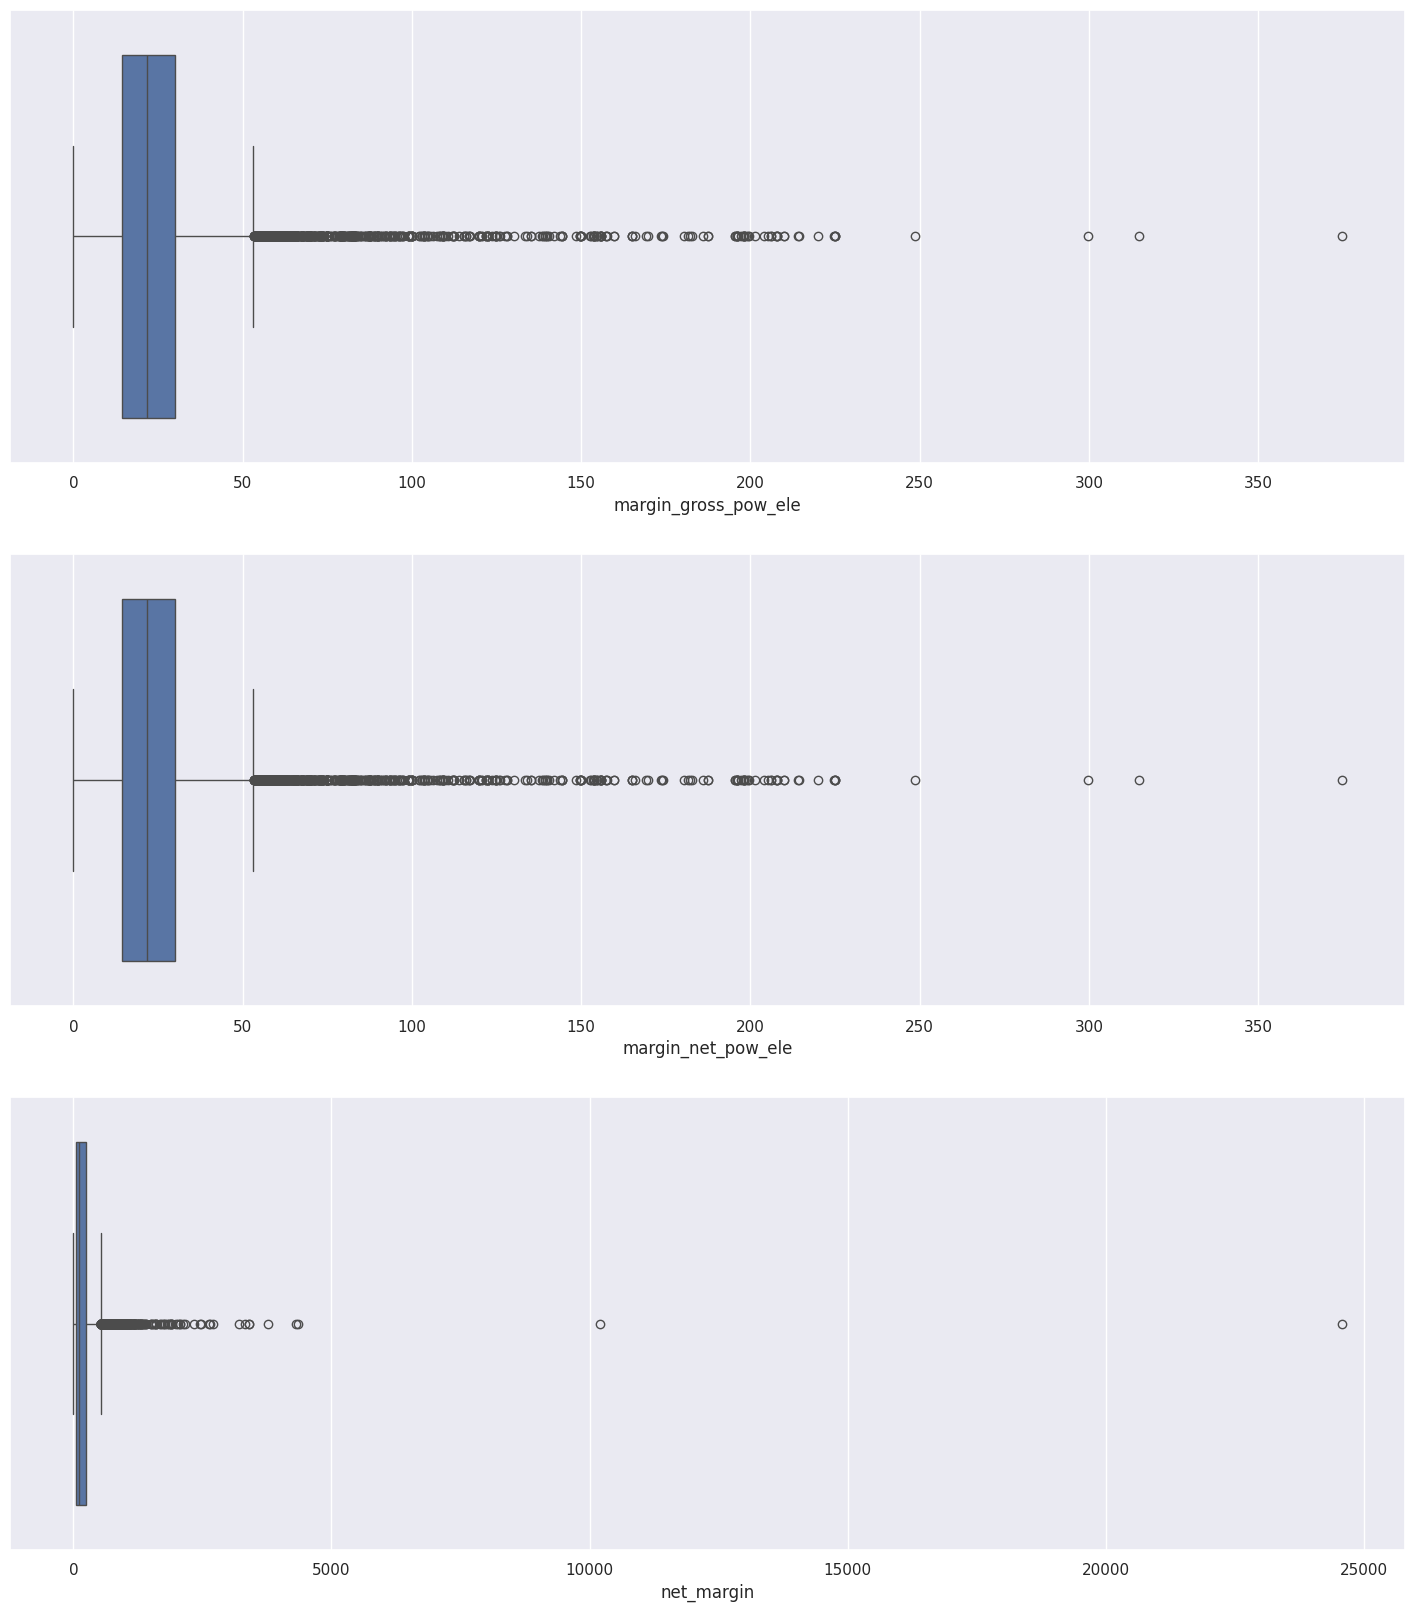

In [23]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))

sns.boxplot(x=client_df['margin_gross_pow_ele'], ax=axs[0])
sns.boxplot(x=client_df['margin_net_pow_ele'], ax=axs[1])
sns.boxplot(x=client_df['net_margin'], ax=axs[2])

for ax in axs:
    ax.ticklabel_format(style='plain', axis='x')
    # axs[0].set_xlim(-200000, 2000000)
    # axs[1].set_xlim(-20000, 100000)
    # axs[2].set_xlim(-200000, 2000000)
    # axs[3].set_xlim(-1000, 10000)
    plt.show()

### Subscribed Power

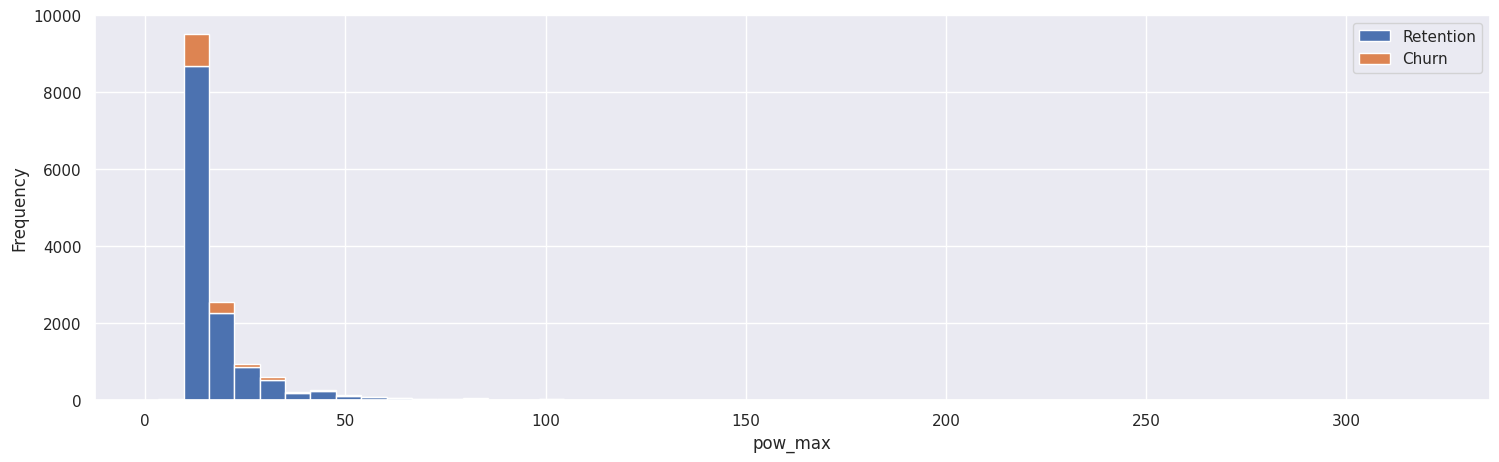

In [24]:
fig, axs = plt.subplots(nrows=1, figsize=(18, 5))

plot_distribution(client_df, 'pow_max', axs)

### Active Products

In [25]:
active_prod = client_df[['id', 'nb_prod_act', 'churn']].groupby(['nb_prod_act', 'churn']).count().unstack().fillna(0)
active_prod_stack = (active_prod.div(active_prod.sum(axis=1), axis=0)*100).sort_values(by=('id', 1), ascending=False)

In [26]:
active_prod_stack

id           
churn                 0          1
nb_prod_act                       
4             90.000000  10.000000
1             90.018371   9.981629
3             90.057361   9.942639
5             90.322581   9.677419
2             91.492843   8.507157
6            100.000000   0.000000
8            100.000000   0.000000
9            100.000000   0.000000
10           100.000000   0.000000
32           100.000000   0.000000

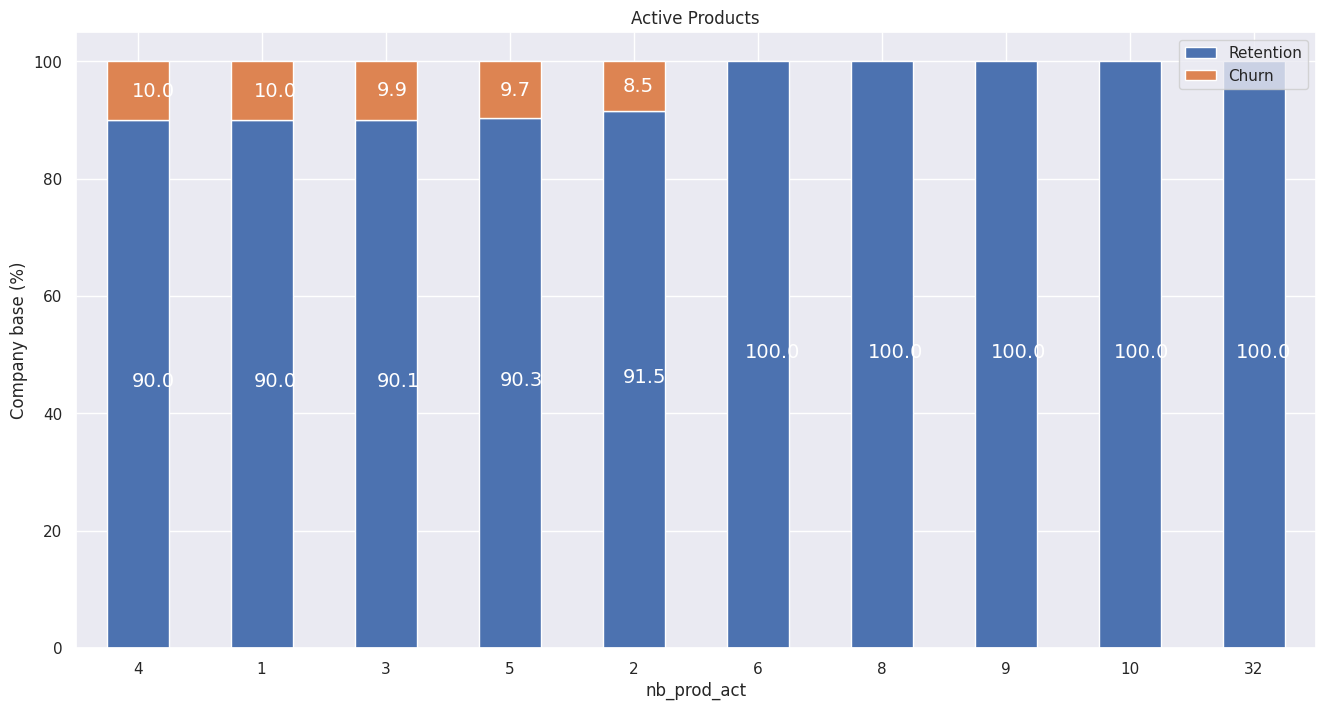

In [27]:
plot_stacked_bars(active_prod_stack, 'Active Products')

### Customer Antiquity

In [28]:
customer_antiq = client_df[['id', 'num_years_antig', 'churn']].groupby(['num_years_antig', 'churn']).count().unstack().fillna(0)
customer_antiq_stack = (customer_antiq.div(customer_antiq.sum(axis=1), axis=0)*100).sort_values(by=('id', 1), ascending=False)

In [29]:
customer_antiq.merge(customer_antiq_stack, left_index=True, right_index=True, suffixes=('_count', '_percentage'))

id_count        id_percentage           
churn                  0      1             0          1
num_years_antig                                         
1                    1.0    0.0    100.000000   0.000000
2                    8.0    3.0     72.727273  27.272727
3                 2104.0  329.0     86.477600  13.522400
4                 3510.0  472.0     88.146660  11.853340
5                 2117.0  200.0     91.368148   8.631852
6                 4430.0  339.0     92.891592   7.108408
7                  467.0   42.0     91.748527   8.251473
8                   98.0    5.0     95.145631   4.854369
9                   91.0    1.0     98.913043   1.086957
10                  77.0    4.0     95.061728   4.938272
11                 173.0   12.0     93.513514   6.486486
12                  99.0   11.0     90.000000  10.000000
13                  12.0    1.0     92.307692   7.692308

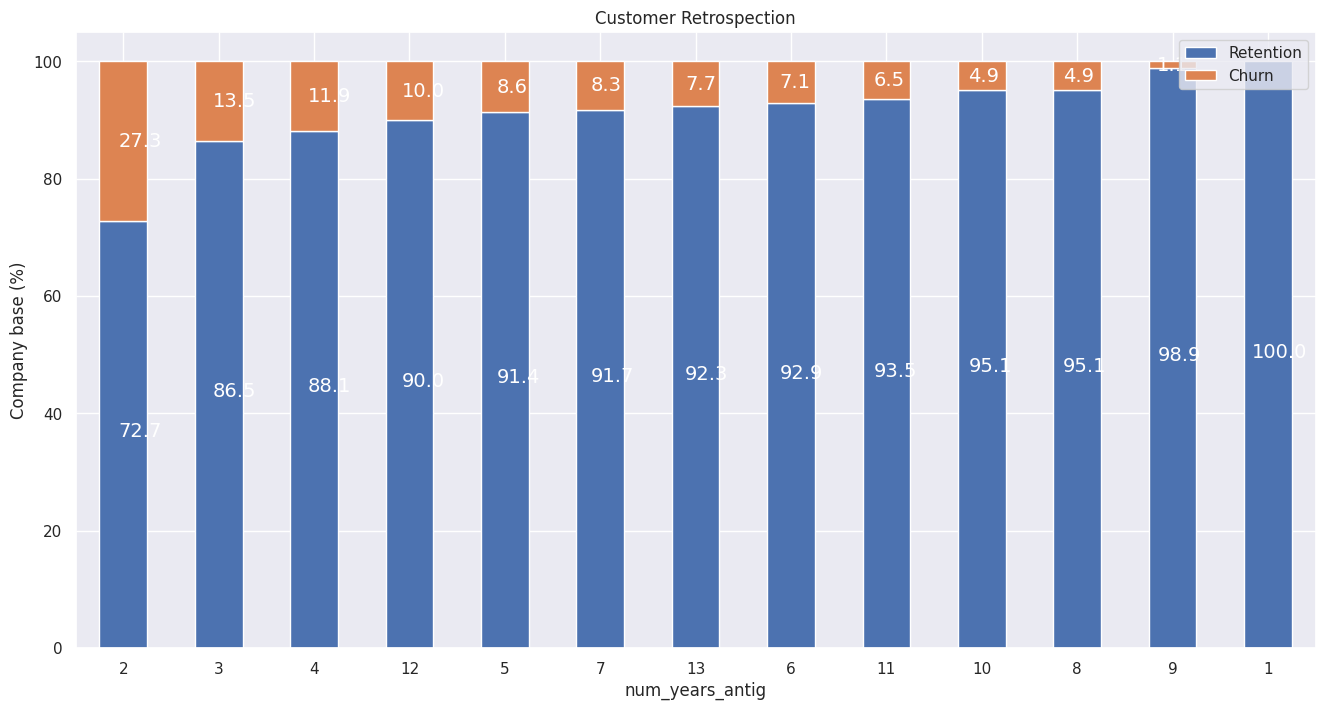

In [30]:
plot_stacked_bars(customer_antiq_stack, 'Customer Retrospection')

In [31]:
client_df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

# Feature Engineering

## Transforming date variables

In [32]:
client_df["date_activ"] = pd.to_datetime(client_df["date_activ"], format='%Y-%m-%d')
client_df["date_end"] = pd.to_datetime(client_df["date_end"], format='%Y-%m-%d')
client_df["date_modif_prod"] = pd.to_datetime(client_df["date_modif_prod"], format='%Y-%m-%d')
client_df["date_renewal"] = pd.to_datetime(client_df["date_renewal"], format='%Y-%m-%d')

To get the most out of the date features, we would convert them into months with a reference date of 2016-01-01. I believe these data points would have more value

In [33]:
reference_date = pd.to_datetime('2016-01-01')
client_df['months_activ'] = np.ceil((reference_date - client_df['date_activ']).dt.days / 30).astype(int)
client_df['months_end'] = np.ceil((reference_date - client_df['date_end']).dt.days / 30).astype(int)
client_df['months_modif'] = np.ceil((reference_date - client_df['date_modif_prod']).dt.days / 30).astype(int)
client_df['months_renewal'] = np.ceil((reference_date - client_df['date_renewal']).dt.days / 30).astype(int)

### Duration

Calculating how long a customer has been with PowerCo in years. This might be an indication of how likely a customer is to churn or not.

In [34]:
# Calculating contract duration
client_df['duration'] = ((client_df['date_end'] - client_df['date_activ']).dt.days/365).astype(int)

In [35]:
client_df.groupby(['duration']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

churn
duration          
2         0.176471
3         0.143874
4         0.127473
13        0.095238
5         0.091999
12        0.083333
7         0.075472
6         0.075407
11        0.059783
8         0.047244
10        0.045455
9         0.012500

Companies who have been less than 5 years with PowerCo have a higher churn rate

## Encoding categorical variables

### has_gas

In [36]:
# Encoding the 'has_gas' variable
client_df['has_gas']=client_df['has_gas'].replace({'t': 1, 'f': 0})

In [37]:
client_df['churn'].groupby(client_df['has_gas']).mean()

has_gas
0    0.100544
1    0.081856
Name: churn, dtype: float64

### sales_channel

In [38]:
client_df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [39]:
# Encoding with one hot encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
channel_sales_encoded = ohe.fit_transform(client_df[['channel_sales']])
channel_sales_df = pd.DataFrame(channel_sales_encoded, columns=ohe.get_feature_names_out(['channel_sales']))
client_df = pd.concat([client_df, channel_sales_df], axis=1).drop('channel_sales', axis=1)


We can see that the last 3 channels have negligible numbers therefore we will drop the corresponding columns

In [40]:
client_df = client_df.drop(columns=['channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa'])

In [41]:
client_df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  forecast_cons_12m  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23               0.00   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31             189.95   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17              47.96   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31             240.04   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09             445.75   

   forecast_cons_year  ...  months_activ  months_end  months_modif  \
0                   0  ...            31          -5             3   
1                   0  ...            78          -8            78   
2                   0  ...            70          -3            70   
3                   0  ...            71          -2            71   
4                 526  ...            73          -2            73   

   months_renewal  duration  channel_sales_MISSING  \
0               7         3                    0.0   
1               5         7                    1.0   
2               9         6                    0.0   
3              10         6                    0.0   
4              10         6                    1.0   

   channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   channel_sales_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                             1.0   
1                                             0.0   
2                                             1.0   
3                                             0.0   
4                                             0.0   

   channel_sales_lmkebamcaaclubfxadlmueccxoimlema  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             1.0   
4                                             0.0   

   channel_sales_usilxuppasemubllopkaafesmlibmsdf  
0                                             0.0  
1                                             0.0  
2                                             0.0  
3                                             0.0  
4                                             0.0  

[5 rows x 35 columns]

### origin_up

In [42]:
client_df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [43]:
# Encoding with one hot encoding
ohe1 = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
origin_up_encoded = ohe1.fit_transform(client_df[['origin_up']])
origin_up_df = pd.DataFrame(origin_up_encoded, columns=ohe1.get_feature_names_out(['origin_up']))
client_df = pd.concat([client_df, origin_up_df], axis=1).drop('origin_up', axis=1)


Just as with origin_up, the last 3 categories are negligible so dropping the columns

In [44]:
client_df = client_df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])

In [45]:
client_df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  forecast_cons_12m  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23               0.00   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31             189.95   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17              47.96   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31             240.04   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09             445.75   

   forecast_cons_year  ...  months_renewal  duration  channel_sales_MISSING  \
0                   0  ...               7         3                    0.0   
1                   0  ...               5         7                    1.0   
2                   0  ...               9         6                    0.0   
3                   0  ...              10         6                    0.0   
4                 526  ...              10         6                    1.0   

   channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   channel_sales_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                             1.0   
1                                             0.0   
2                                             1.0   
3                                             0.0   
4                                             0.0   

   channel_sales_lmkebamcaaclubfxadlmueccxoimlema  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             1.0   
4                                             0.0   

   channel_sales_usilxuppasemubllopkaafesmlibmsdf  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                         0.0   
1                                         1.0   
2                                         1.0   
3                                         1.0   
4                                         1.0   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                         1.0  
1                                         0.0  
2                                         0.0  
3                                         0.0  
4                                         0.0  

[5 rows x 37 columns]

## Transforming Numerical Variables

During EDA, we identified numerical variables that were highly skewed. They will now be transformed using the Logarithmic transformation which is great for positively skewed variables. Our features do have 0 values so we will be adding 1 as a constant value.

In [46]:
numerical_variables = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max']

We will display the statistics before and after transformation for comparison

In [47]:
client_df[numerical_variables].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.795000   
75%           1745.750000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak      imp_cons  margin_gross_pow_ele  \
count                 14606.000000  14606.000000          14606.000000   
mean                     43.130056    152.786896             24.565121   
std                       4.485988    341.369366             20.231172   
min                       0.000000      0.000000              0.000000   
25%                      40.606701      0.000000             14.280000   
50%                      44.311378     37.395000             21.640000   
75%                      44.311378    193.980000             29.880000   
max                      59.266378  15042.790000            374.640000   

       margin_net_pow_ele    net_margin       pow_max  
count        14606.000000  14606.000000  14606.000000  
mean            24.562517    189.264522     18.135136  
std             20.230280    311.798130     13.534743  
min              0.000000      0.000000      3.300000  
25%             14.280000     50.712500     12.500000  
50%             21.640000    112.530000     13.856000  
75%             29.880000    243.097500     19.172500  
max            374.640000  24570.650000    320.000000

In [48]:
# Apply logarithmic transformation
client_df['cons_12m'] = np.log10(client_df['cons_12m'] + 1)
client_df['cons_gas_12m'] = np.log10(client_df['cons_gas_12m'] + 1)
client_df['cons_last_month'] = np.log10(client_df['cons_last_month'] + 1)
client_df['forecast_cons_12m'] = np.log10(client_df['forecast_cons_12m'] + 1)
client_df['forecast_cons_year'] = np.log10(client_df['forecast_cons_year'] + 1)
client_df['forecast_meter_rent_12m'] = np.log10(client_df['forecast_meter_rent_12m'] + 1)
client_df['imp_cons'] = np.log10(client_df['imp_cons'] + 1)
client_df['margin_gross_pow_ele'] = np.log10(client_df['margin_gross_pow_ele'] + 1)
client_df['margin_net_pow_ele'] = np.log10(client_df['margin_net_pow_ele'] + 1)
client_df['net_margin'] = np.log10(client_df['net_margin'] + 1)
client_df['pow_max'] = np.log10(client_df['pow_max'] + 1)

In [49]:
client_df[numerical_variables].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14606.000000  14606.000000     14606.000000       14606.000000   
mean       4.223939      0.779244         2.264646           2.962177   
std        0.884515      1.717071         1.769305           0.683592   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.754023      0.000000         0.000000           2.695477   
50%        4.149727      0.000000         2.899547           3.046836   
75%        4.610285      0.000000         3.529430           3.380716   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean             1.784610                  0.966726                 1.517203   
std              1.584986                  5.108289                 0.571481   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 1.235023   
50%              2.498311                  0.000000                 1.296555   
75%              3.242231                  0.000000                 2.120673   
max              5.243970                 30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak      imp_cons  margin_gross_pow_ele  \
count                 14606.000000  14606.000000          14606.000000   
mean                     43.130056      1.240750              1.300016   
std                       4.485988      1.138322              0.340539   
min                       0.000000      0.000000              0.000000   
25%                      40.606701      0.000000              1.184123   
50%                      44.311378      1.584275              1.354876   
75%                      44.311378      2.289990              1.489677   
max                      59.266378      4.177357              2.574772   

       margin_net_pow_ele    net_margin       pow_max  
count        14606.000000  14606.000000  14606.000000  
mean             1.299972      2.010007      1.231289  
std              0.340532      0.551834      0.182071  
min              0.000000      0.000000      0.633468  
25%              1.184123      1.713596      1.130334  
50%              1.354876      2.055111      1.171902  
75%              1.489677      2.387563      1.304760  
max              2.574772      4.390434      2.506505

The standard deviation is better now

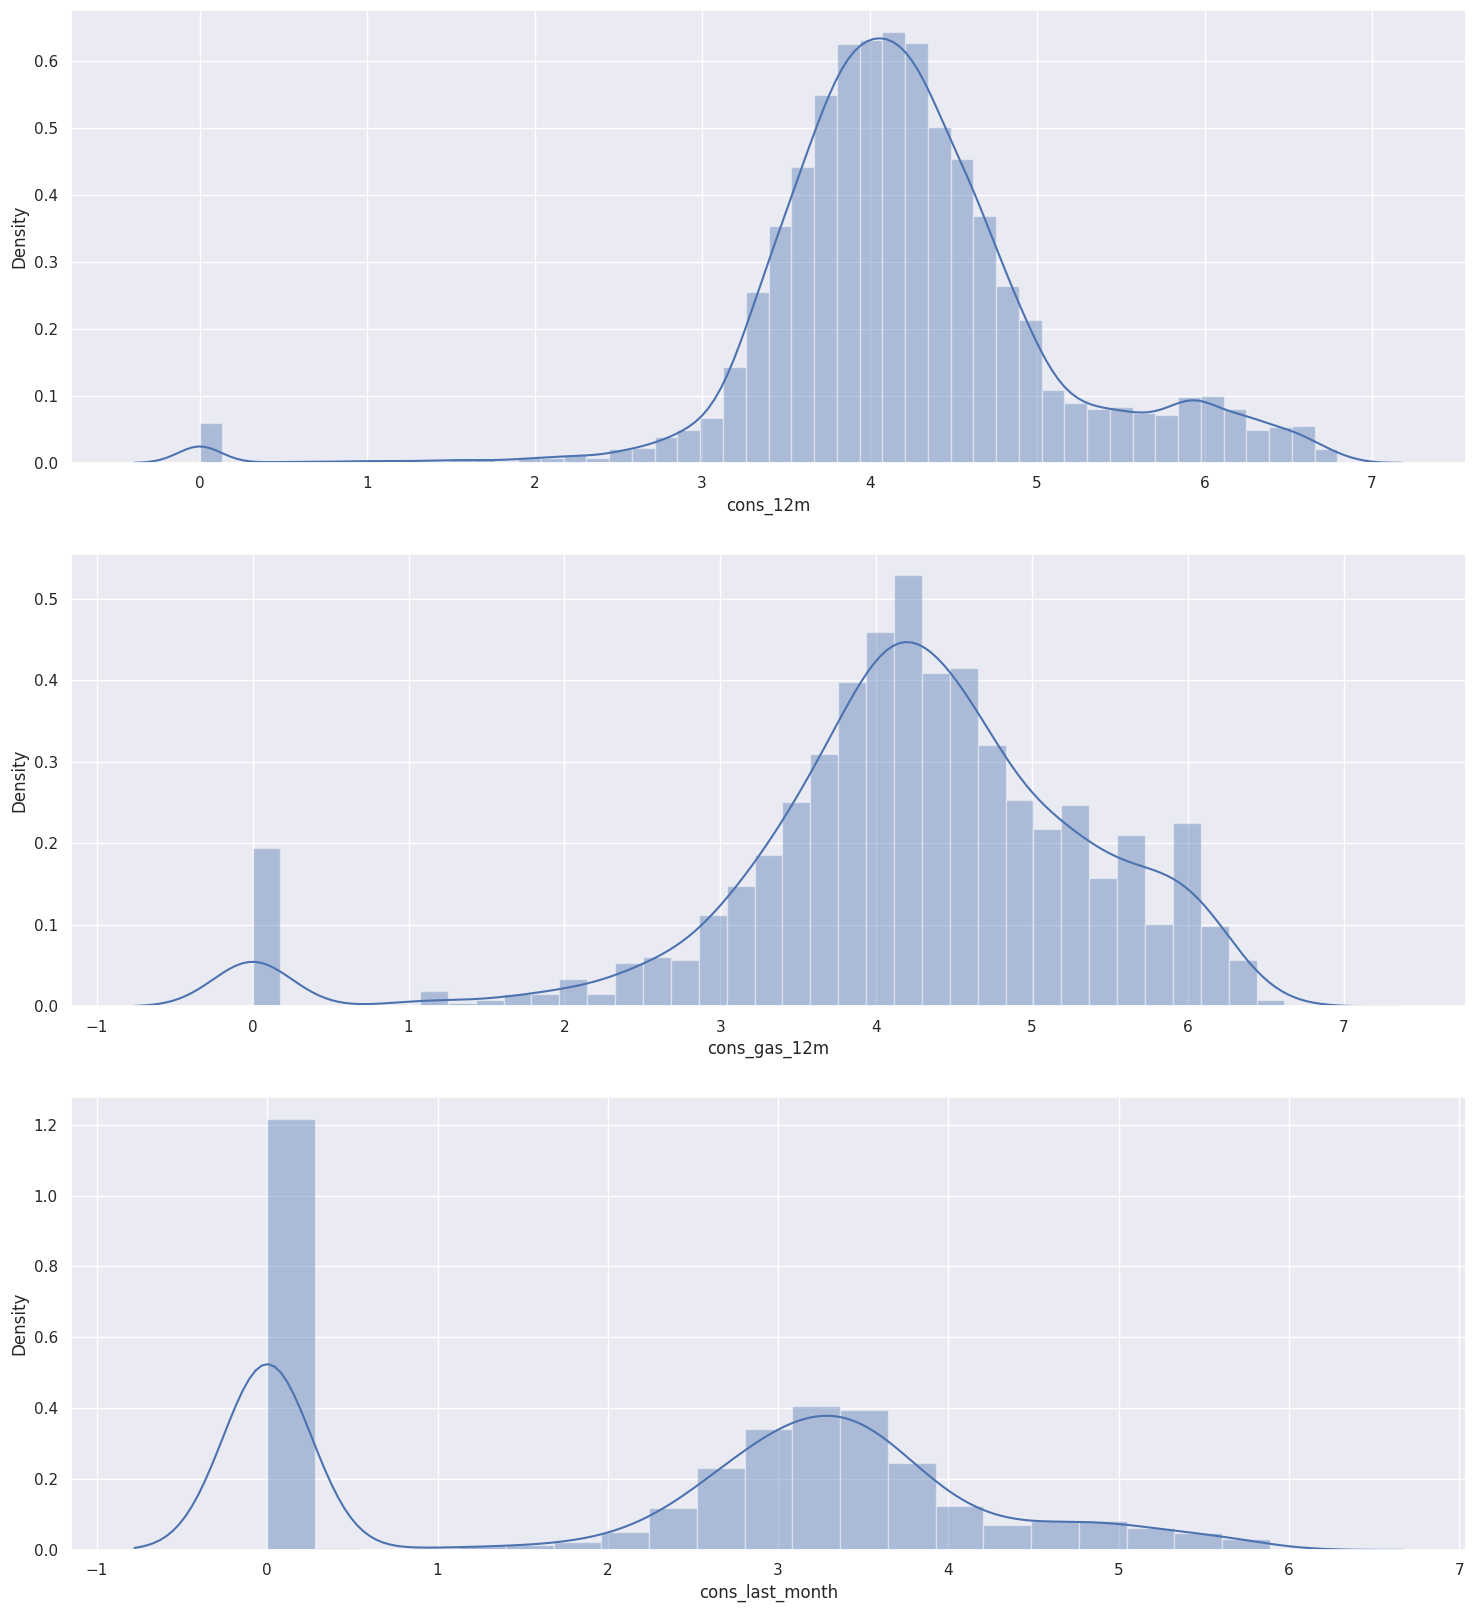

In [50]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((client_df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((client_df[client_df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((client_df["cons_last_month"].dropna()), ax=axs[2])
plt.show()


## Difference between off-peak prices in December and preceding January



In [51]:
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [52]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean',
                                                                  'price_off_peak_fix': 'mean',
                                                                  'price_peak_var': 'mean',
                                                                  'price_peak_fix': 'mean',
                                                                  'price_mid_peak_var': 'mean',
                                                                  'price_mid_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_off_peak_var',
                                                    'price_off_peak_fix': 'dec_off_peak_fix',
                                                    'price_peak_var': 'dec_peak_var',
                                                    'price_peak_fix': 'dec_peak_fix',
                                                    'price_mid_peak_var': 'dec_mid_peak_var',
                                                    'price_mid_peak_fix': 'dec_mid_peak_fix'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_off_peak_var'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_off_peak_fix'] - diff['price_off_peak_fix']
diff['peak_diff_dec_january_energy'] = diff['dec_peak_var'] - diff['price_peak_var']
diff['peak_diff_dec_january_power'] = diff['dec_peak_fix'] - diff['price_peak_fix']
diff['midpeak_diff_dec_january_energy'] = diff['dec_mid_peak_var'] - diff['price_mid_peak_var']
diff['midpeak_diff_dec_january_power'] = diff['dec_mid_peak_fix'] - diff['price_mid_peak_fix']
# Extracting the price difference into a new dataframe
diff_prices = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy', 'peak_diff_dec_january_power', 'midpeak_diff_dec_january_energy', 'midpeak_diff_dec_january_power']]
diff_prices.head(3)

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   

   offpeak_diff_dec_january_power  peak_diff_dec_january_energy  \
0                        0.162916                     -0.002302   
1                        0.177779                      0.000000   
2                        1.500000                      0.000000   

   peak_diff_dec_january_power  midpeak_diff_dec_january_energy  \
0                     0.097749                         0.003487   
1                     0.000000                         0.000000   
2                     0.000000                         0.000000   

   midpeak_diff_dec_january_power  
0                        0.065166  
1                        0.000000  
2                        0.000000

In [53]:
client_df = pd.merge(client_df, diff_prices, on='id')

## Average price changes across peak periods

In [54]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [55]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [56]:
columns = [
    'id',
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff',
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff',
    'peak_mid_peak_fix_mean_diff',
    'off_peak_mid_peak_fix_mean_diff'
]
client_df = pd.merge(client_df, mean_prices[columns], on='id')
client_df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944         0.000000   
1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000         0.000000   
2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000         0.000000   
3  bba03439a292a1e166f80264c16191cb  3.200029      0.000000         0.000000   
4  149d57cf92fc41cf94415803a877cb4b  3.646011      0.000000         2.721811   

  date_activ   date_end date_modif_prod date_renewal  forecast_cons_12m  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23           0.000000   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31           2.280920   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17           1.689841   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31           2.382089   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09           2.650065   

   forecast_cons_year  ...  peak_diff_dec_january_energy  \
0            0.000000  ...                     -0.017912   
1            0.000000  ...                      0.000000   
2            0.000000  ...                      0.000528   
3            0.000000  ...                      0.000000   
4            2.721811  ...                     -0.002302   

   peak_diff_dec_january_power  midpeak_diff_dec_january_energy  \
0                   -24.339581                        -0.071536   
1                     0.000000                         0.000000   
2                     0.000000                         0.000000   
3                     0.000000                         0.000000   
4                     0.097749                         0.003487   

   midpeak_diff_dec_january_power  off_peak_peak_var_mean_diff  \
0                      -16.226389                     0.024038   
1                        0.000000                     0.142485   
2                        0.000000                     0.082090   
3                        0.000000                     0.151210   
4                        0.065166                     0.020536   

   peak_mid_peak_var_mean_diff  off_peak_mid_peak_var_mean_diff  \
0                     0.034219                         0.058257   
1                     0.007124                         0.149609   
2                     0.088421                         0.170512   
3                     0.000000                         0.151210   
4                     0.030773                         0.051309   

   off_peak_peak_fix_mean_diff  peak_mid_peak_fix_mean_diff  \
0                    18.590255                     7.450670   
1                    44.311375                     0.000000   
2                    44.385450                     0.000000   
3                    44.400265                     0.000000   
4                    16.275263                     8.137629   

   off_peak_mid_peak_fix_mean_diff  
0                        26.040925  
1                        44.311375  
2                        44.385450  
3                        44.400265  
4                        24.412893  

[5 rows x 49 columns]

### Maximum price changes across periods and months

In [57]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [58]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [59]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [60]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

client_df = pd.merge(client_df, max_diff_across_periods_months[columns], on='id')
client_df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944         0.000000   
1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000         0.000000   
2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000         0.000000   
3  bba03439a292a1e166f80264c16191cb  3.200029      0.000000         0.000000   
4  149d57cf92fc41cf94415803a877cb4b  3.646011      0.000000         2.721811   

  date_activ   date_end date_modif_prod date_renewal  forecast_cons_12m  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23           0.000000   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31           2.280920   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17           1.689841   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31           2.382089   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09           2.650065   

   forecast_cons_year  ...  off_peak_mid_peak_var_mean_diff  \
0            0.000000  ...                         0.058257   
1            0.000000  ...                         0.149609   
2            0.000000  ...                         0.170512   
3            0.000000  ...                         0.151210   
4            2.721811  ...                         0.051309   

   off_peak_peak_fix_mean_diff  peak_mid_peak_fix_mean_diff  \
0                    18.590255                     7.450670   
1                    44.311375                     0.000000   
2                    44.385450                     0.000000   
3                    44.400265                     0.000000   
4                    16.275263                     8.137629   

   off_peak_mid_peak_fix_mean_diff  off_peak_peak_var_max_monthly_diff  \
0                        26.040925                            0.060550   
1                        44.311375                            0.151367   
2                        44.385450                            0.084587   
3                        44.400265                            0.153133   
4                        24.412893                            0.022225   

   peak_mid_peak_var_max_monthly_diff  off_peak_mid_peak_var_max_monthly_diff  \
0                            0.085483                                0.146033   
1                            0.085483                                0.151367   
2                            0.089162                                0.172468   
3                            0.000000                                0.153133   
4                            0.033743                                0.055866   

   off_peak_peak_fix_max_monthly_diff  peak_mid_peak_fix_max_monthly_diff  \
0                           44.266930                            8.145775   
1                           44.444710                            0.000000   
2                           44.444710                            0.000000   
3                           44.444710                            0.000000   
4                           16.291555                            8.145775   

   off_peak_mid_peak_fix_max_monthly_diff  
0                                44.26693  
1                                44.44471  
2                                44.44471  
3                                44.44471  
4                                24.43733  

[5 rows x 55 columns]

## Dropping Features

In [61]:
# Removing the gross margin on power sub as it correlates perfectly with the net margin

client_df = client_df.drop('margin_gross_pow_ele', axis=1)
client_df = client_df.drop(columns=['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])

## Correlation check

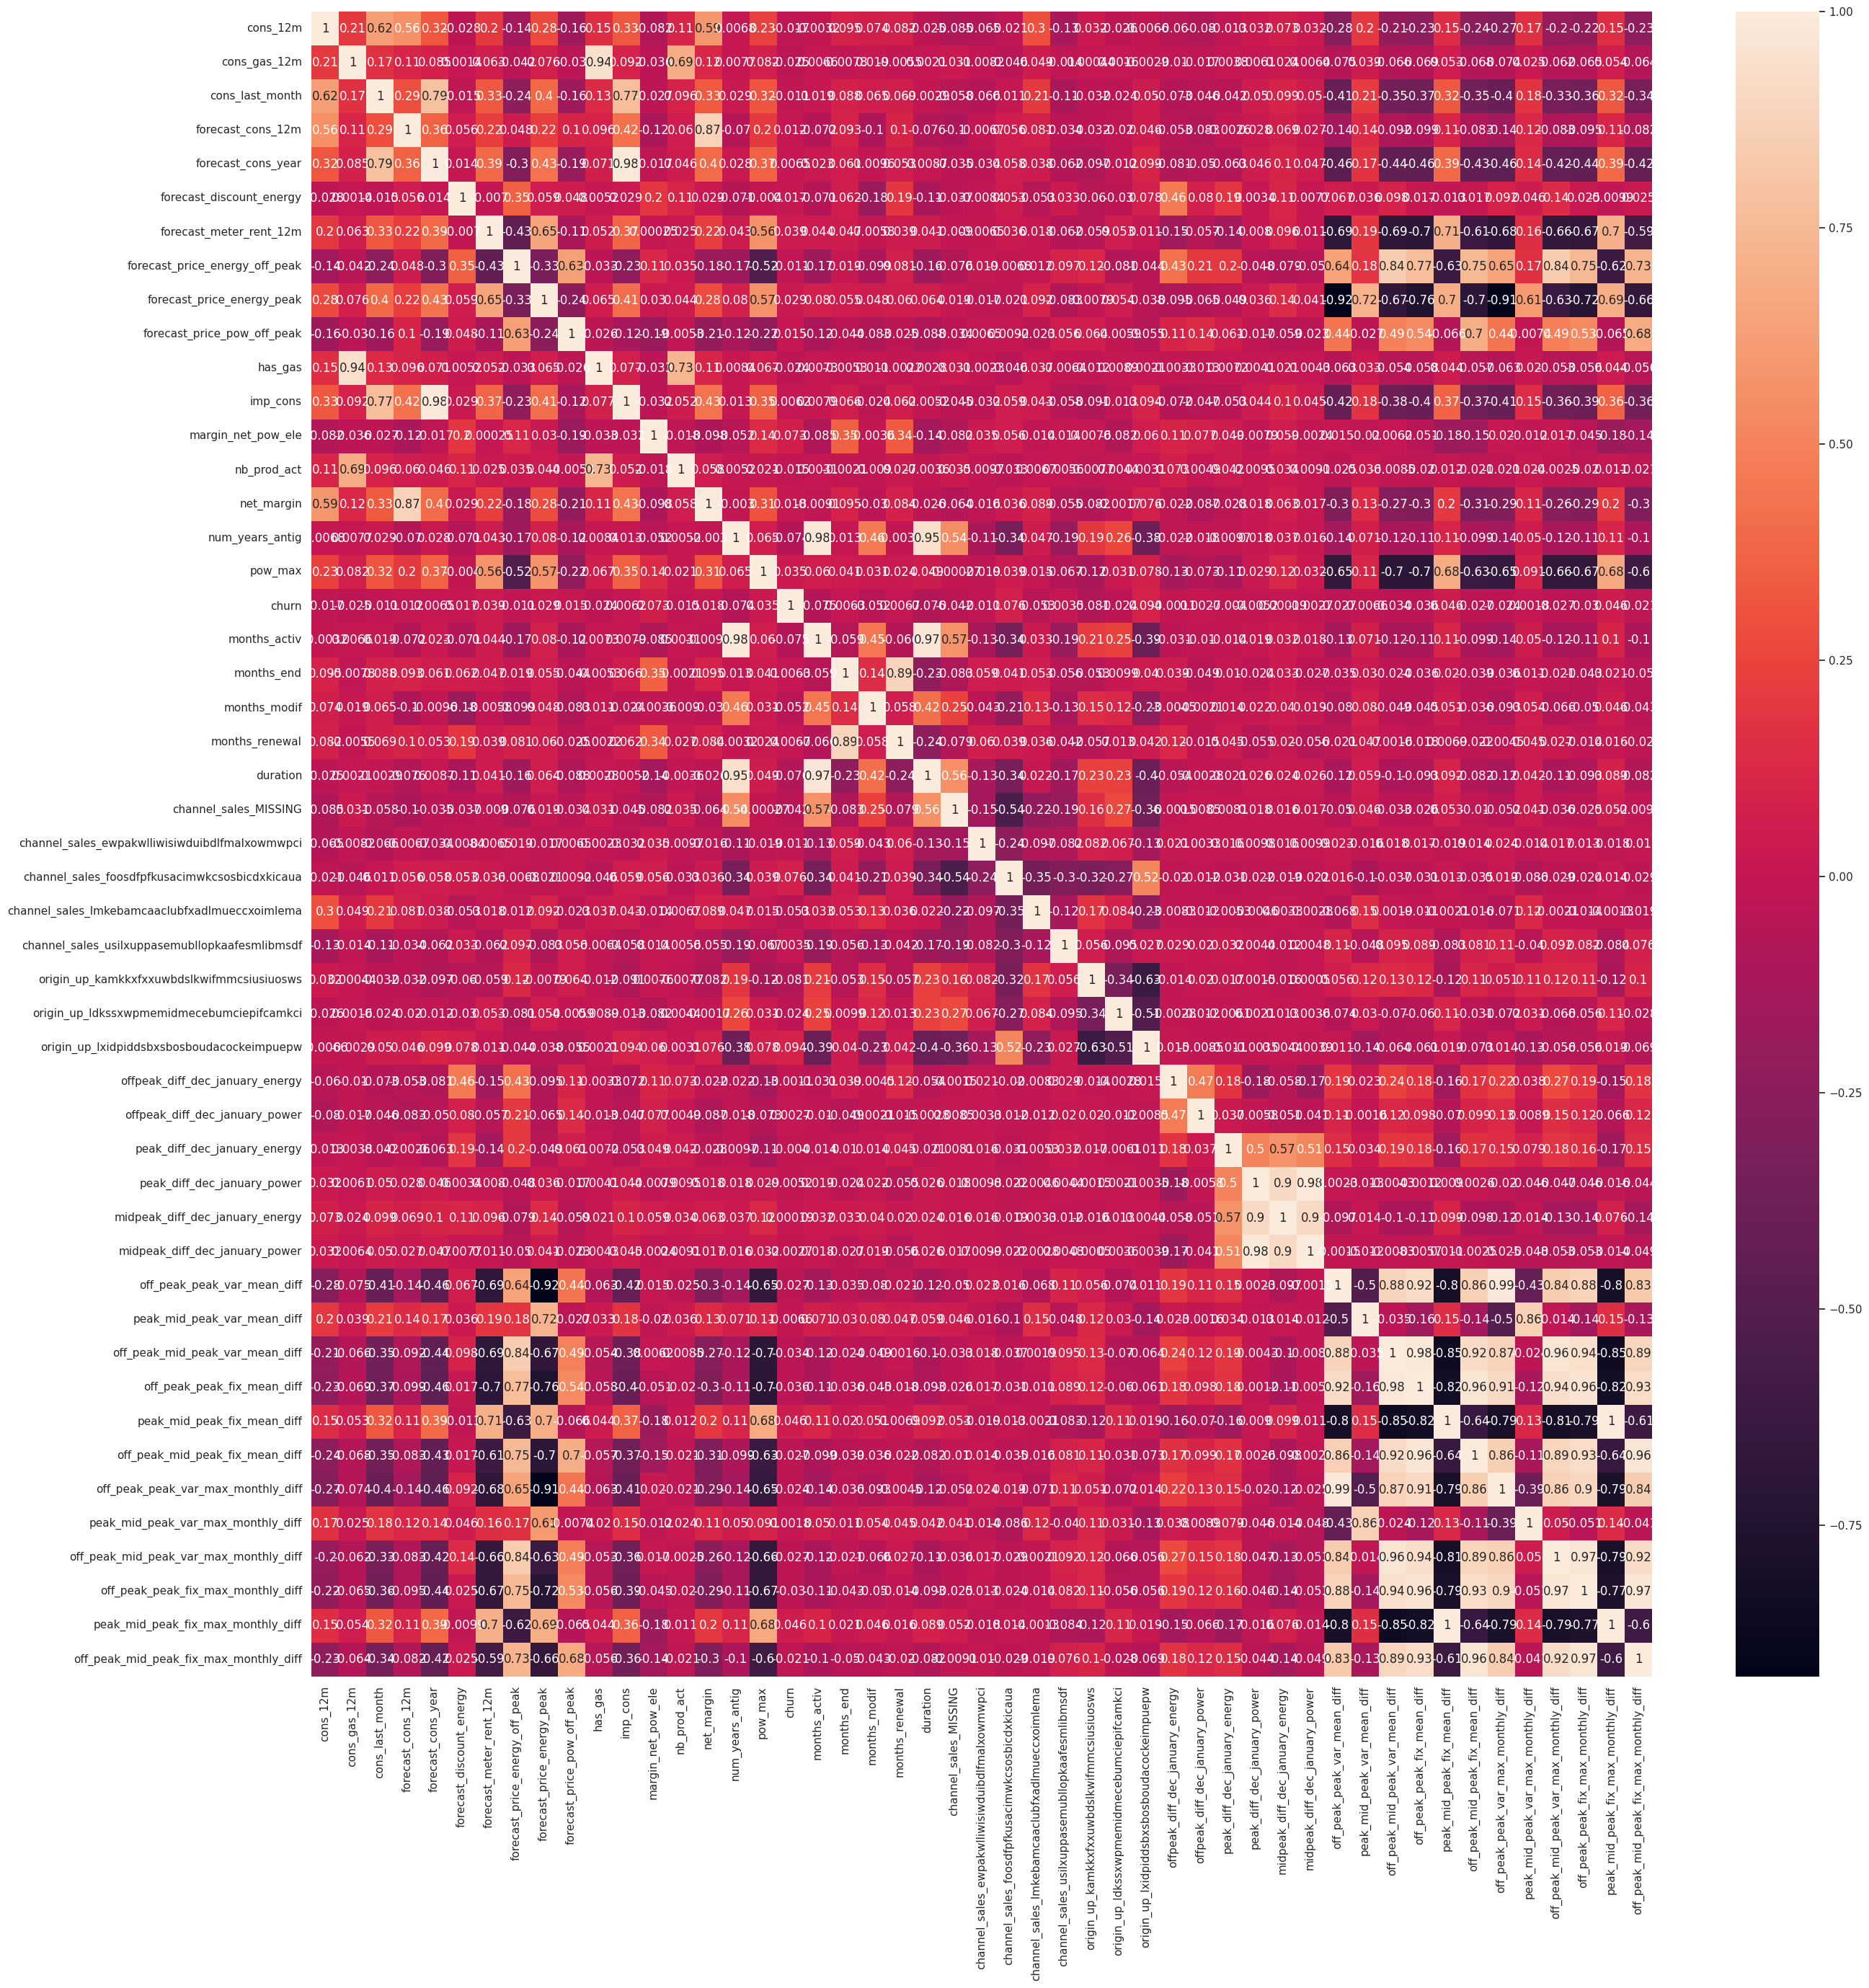

In [62]:
plt.figure(figsize=(30, 30))
sns.heatmap(client_df.corr(numeric_only=True), annot=True)
plt.show()

# Model Development

In [63]:
client_df.churn.value_counts()

churn
0    13187
1     1419
Name: count, dtype: int64

### Data sampling

From the cell above, we can see that our target class is heavily imbalanced so that would be the first thing to tackle.

But before that, we split our dataset into training and test samples.

In [367]:
# Make a copy of our data
train_df = client_df.copy()

# Separate target variable from independent variables
y = client_df['churn']
X = client_df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 48)
(14606,)


In [368]:
X_train_s, X_test, y_train_s, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 48)
(10954,)
(3652, 48)
(3652,)


A quick check shows that the dataset is not balanced so we are going to apply sampling techniques

In [369]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_s, y_train_s = smote.fit_resample(X_train, y_train)

In [370]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=42)
# X_train_s, y_train_s = rus.fit_resample(X_train, y_train)

### Model training

In [391]:
feature_model = RandomForestClassifier(bootstrap= True, max_depth= 17, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 77, )
feature_model.fit(X_train_s, y_train_s)

RandomForestClassifier(max_depth=17, min_samples_leaf=2, n_estimators=77)

### QTest

In [355]:
X_train_s = X_train_s.to_numpy()
y_train_s = y_train_s.to_numpy()

In [356]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_s)

In [357]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 20, 350),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'random_state': 42,
        'n_jobs': -1
    }

    model = lgb.LGBMClassifier(**params)

    # Using StratifiedKFold for cross-validation with sample weights
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in skf.split(X_train_s, y_train_s):
        X_train_fold, X_val_fold = X_train_s[train_index], X_train_s[val_index]
        y_train_fold, y_val_fold = y_train_s[train_index], y_train_s[val_index]

        # Get sample weights for the current fold
        fold_weights = sample_weights[train_index]

        model.fit(X_train_fold, y_train_fold, sample_weight=fold_weights)
        y_pred_fold = model.predict(X_val_fold)
        scores.append(fbeta_score(y_val_fold, y_pred_fold, beta=3))

    return np.mean(scores)


In [358]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, timeout=600)  # adjust trials/time as needed

print("Best parameters:", study.best_params)
print("Best F1 score:", study.best_value)

[I 2025-05-08 09:50:18,690] A new study created in memory with name: no-name-203e4b70-bbdc-4c24-a008-a00e464d6a06


[LightGBM] [Info] Number of positive: 702, number of negative: 6600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6031
[LightGBM] [Info] Number of data points in the train set: 7302, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000101
[LightGBM] [Info] Start training from score 0.000101
[LightGBM] [Info] Number of positive: 702, number of negative: 6601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6037
[LightGBM] [Info] Number of data points in the train set: 7303, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499987 -> initscore=-0.000050
[LightGBM] [Info] Start training from score -0.000050
[LightGBM] [Info] Numb

[I 2025-05-08 09:50:20,520] Trial 0 finished with value: 0.2152946569944504 and parameters: {'learning_rate': 0.21750604995506356, 'num_leaves': 48, 'max_depth': 17, 'min_child_samples': 19, 'subsample': 0.660028611599119, 'colsample_bytree': 0.8121378299754454, 'n_estimators': 136}. Best is trial 0 with value: 0.2152946569944504.


[LightGBM] [Info] Number of positive: 702, number of negative: 6600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6031
[LightGBM] [Info] Number of data points in the train set: 7302, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000101
[LightGBM] [Info] Start training from score 0.000101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-05-08 09:50:29,917] Trial 1 finished with value: 0.18165899184152437 and parameters: {'learning_rate': 0.3453257472265966, 'num_leaves': 221, 'max_depth': 40, 'min_child_samples': 73, 'subsample': 0.6566882805031222, 'colsample_bytree': 0.5571752529881344, 'n_estimators': 728}. Best is trial 0 with value: 0.2152946569944504.


[LightGBM] [Info] Number of positive: 702, number of negative: 6600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6031
[LightGBM] [Info] Number of data points in the train set: 7302, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000101
[LightGBM] [Info] Start training from score 0.000101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-05-08 09:51:00,215] Trial 2 finished with value: 0.24057582257311708 and parameters: {'learning_rate': 0.03434752518526018, 'num_leaves': 97, 'max_depth': 27, 'min_child_samples': 78, 'subsample': 0.6218645633752424, 'colsample_bytree': 0.9784908003924861, 'n_estimators': 708}. Best is trial 2 with value: 0.24057582257311708.


[LightGBM] [Info] Number of positive: 702, number of negative: 6600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6031
[LightGBM] [Info] Number of data points in the train set: 7302, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000101
[LightGBM] [Info] Start training from score 0.000101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-05-08 09:51:02,157] Trial 3 finished with value: 0.43201102966743515 and parameters: {'learning_rate': 0.4298343059448122, 'num_leaves': 323, 'max_depth': 1, 'min_child_samples': 91, 'subsample': 0.7966056369018513, 'colsample_bytree': 0.6949389331980429, 'n_estimators': 724}. Best is trial 3 with value: 0.43201102966743515.


[LightGBM] [Info] Number of positive: 702, number of negative: 6600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6031
[LightGBM] [Info] Number of data points in the train set: 7302, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000101
[LightGBM] [Info] Start training from score 0.000101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-05-08 09:51:16,180] Trial 4 finished with value: 0.22649614474072946 and parameters: {'learning_rate': 0.07187419705349758, 'num_leaves': 153, 'max_depth': 22, 'min_child_samples': 94, 'subsample': 0.914339599334002, 'colsample_bytree': 0.7629492294261706, 'n_estimators': 757}. Best is trial 3 with value: 0.43201102966743515.


Best parameters: {'learning_rate': 0.4298343059448122, 'num_leaves': 323, 'max_depth': 1, 'min_child_samples': 91, 'subsample': 0.7966056369018513, 'colsample_bytree': 0.6949389331980429, 'n_estimators': 724}
Best F1 score: 0.43201102966743515


In [401]:
best_params = {'learning_rate': 0.4298343059448122, 'num_leaves': 323, 'max_depth': 1, 'min_child_samples': 91, 'subsample': 0.7966056369018513, 'colsample_bytree': 0.6949389331980429, 'n_estimators': 724}
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_logloss'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train_s, y_train_s, sample_weight=sample_weights)

y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))


[LightGBM] [Info] Number of positive: 1053, number of negative: 9901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6153
[LightGBM] [Info] Number of data points in the train set: 10954, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [402]:
# prompt: Do a voting classifier with lgbm

from sklearn.ensemble import VotingClassifier

# Assuming 'final_model' (LGBM) and 'feature_model' (RandomForest) are already defined and trained

voting_clf = VotingClassifier(estimators=[('lgbm', final_model), ('rf', feature_model)], voting='soft') # You can change voting to 'hard' if needed
voting_clf.fit(X_train_s, y_train_s, sample_weight=sample_weights) # Use sample weights if applicable

y_pred_voting = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred_voting, digits=3))


[LightGBM] [Info] Number of positive: 1053, number of negative: 9901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6153
[LightGBM] [Info] Number of data points in the train set: 10954, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [403]:
print(accuracy_score(y_test, y_pred_voting))
print(f1_score(y_test, y_pred_voting))
print(precision_score(y_test, y_pred_voting))
print(recall_score(y_test, y_pred_voting))

0.8669222343921139
0.2831858407079646
0.3076923076923077
0.26229508196721313


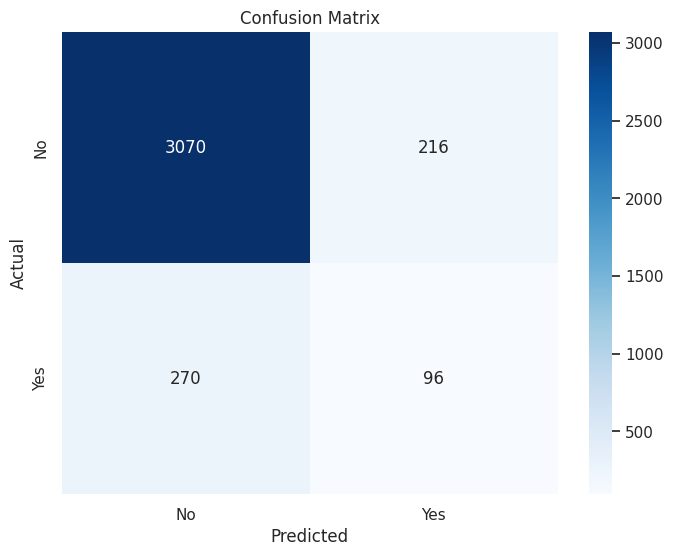

In [404]:
cm = confusion_matrix(y_test, y_pred_voting)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

In [372]:
# Generate predictions here!
y_pred = model.predict(X_test)

In [374]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

Using a mmore robust list of performance metrics to evaluate model performance because of the unbalanced nature of the class.

The accuracy metric would not be a correct depiction of the model performance as it could just output the majority class a lot of times.

In [375]:
accuracy_score(y_test, y_pred)

0.7751916757940854

In [376]:
precision_score(y_test, y_pred)

0.2079589216944801

In [377]:
recall_score(y_test, y_pred)

0.4426229508196721

In [378]:
f1_score(y_test, y_pred)

0.28296943231441046

In [365]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.71      0.81      3286
           1       0.16      0.49      0.24       366

    accuracy                           0.69      3652
   macro avg       0.54      0.60      0.52      3652
weighted avg       0.85      0.69      0.75      3652



In [364]:
confusion_matrix(y_test, y_pred)

array([[2341,  945],
       [ 186,  180]])

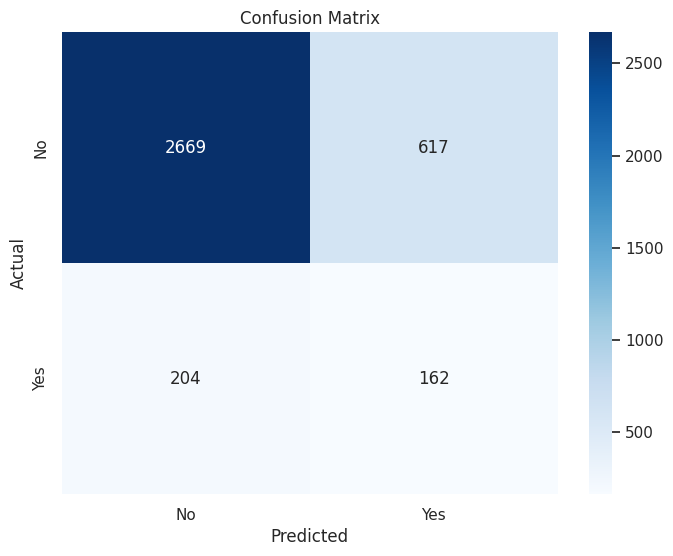

In [396]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Model understanding


In [385]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

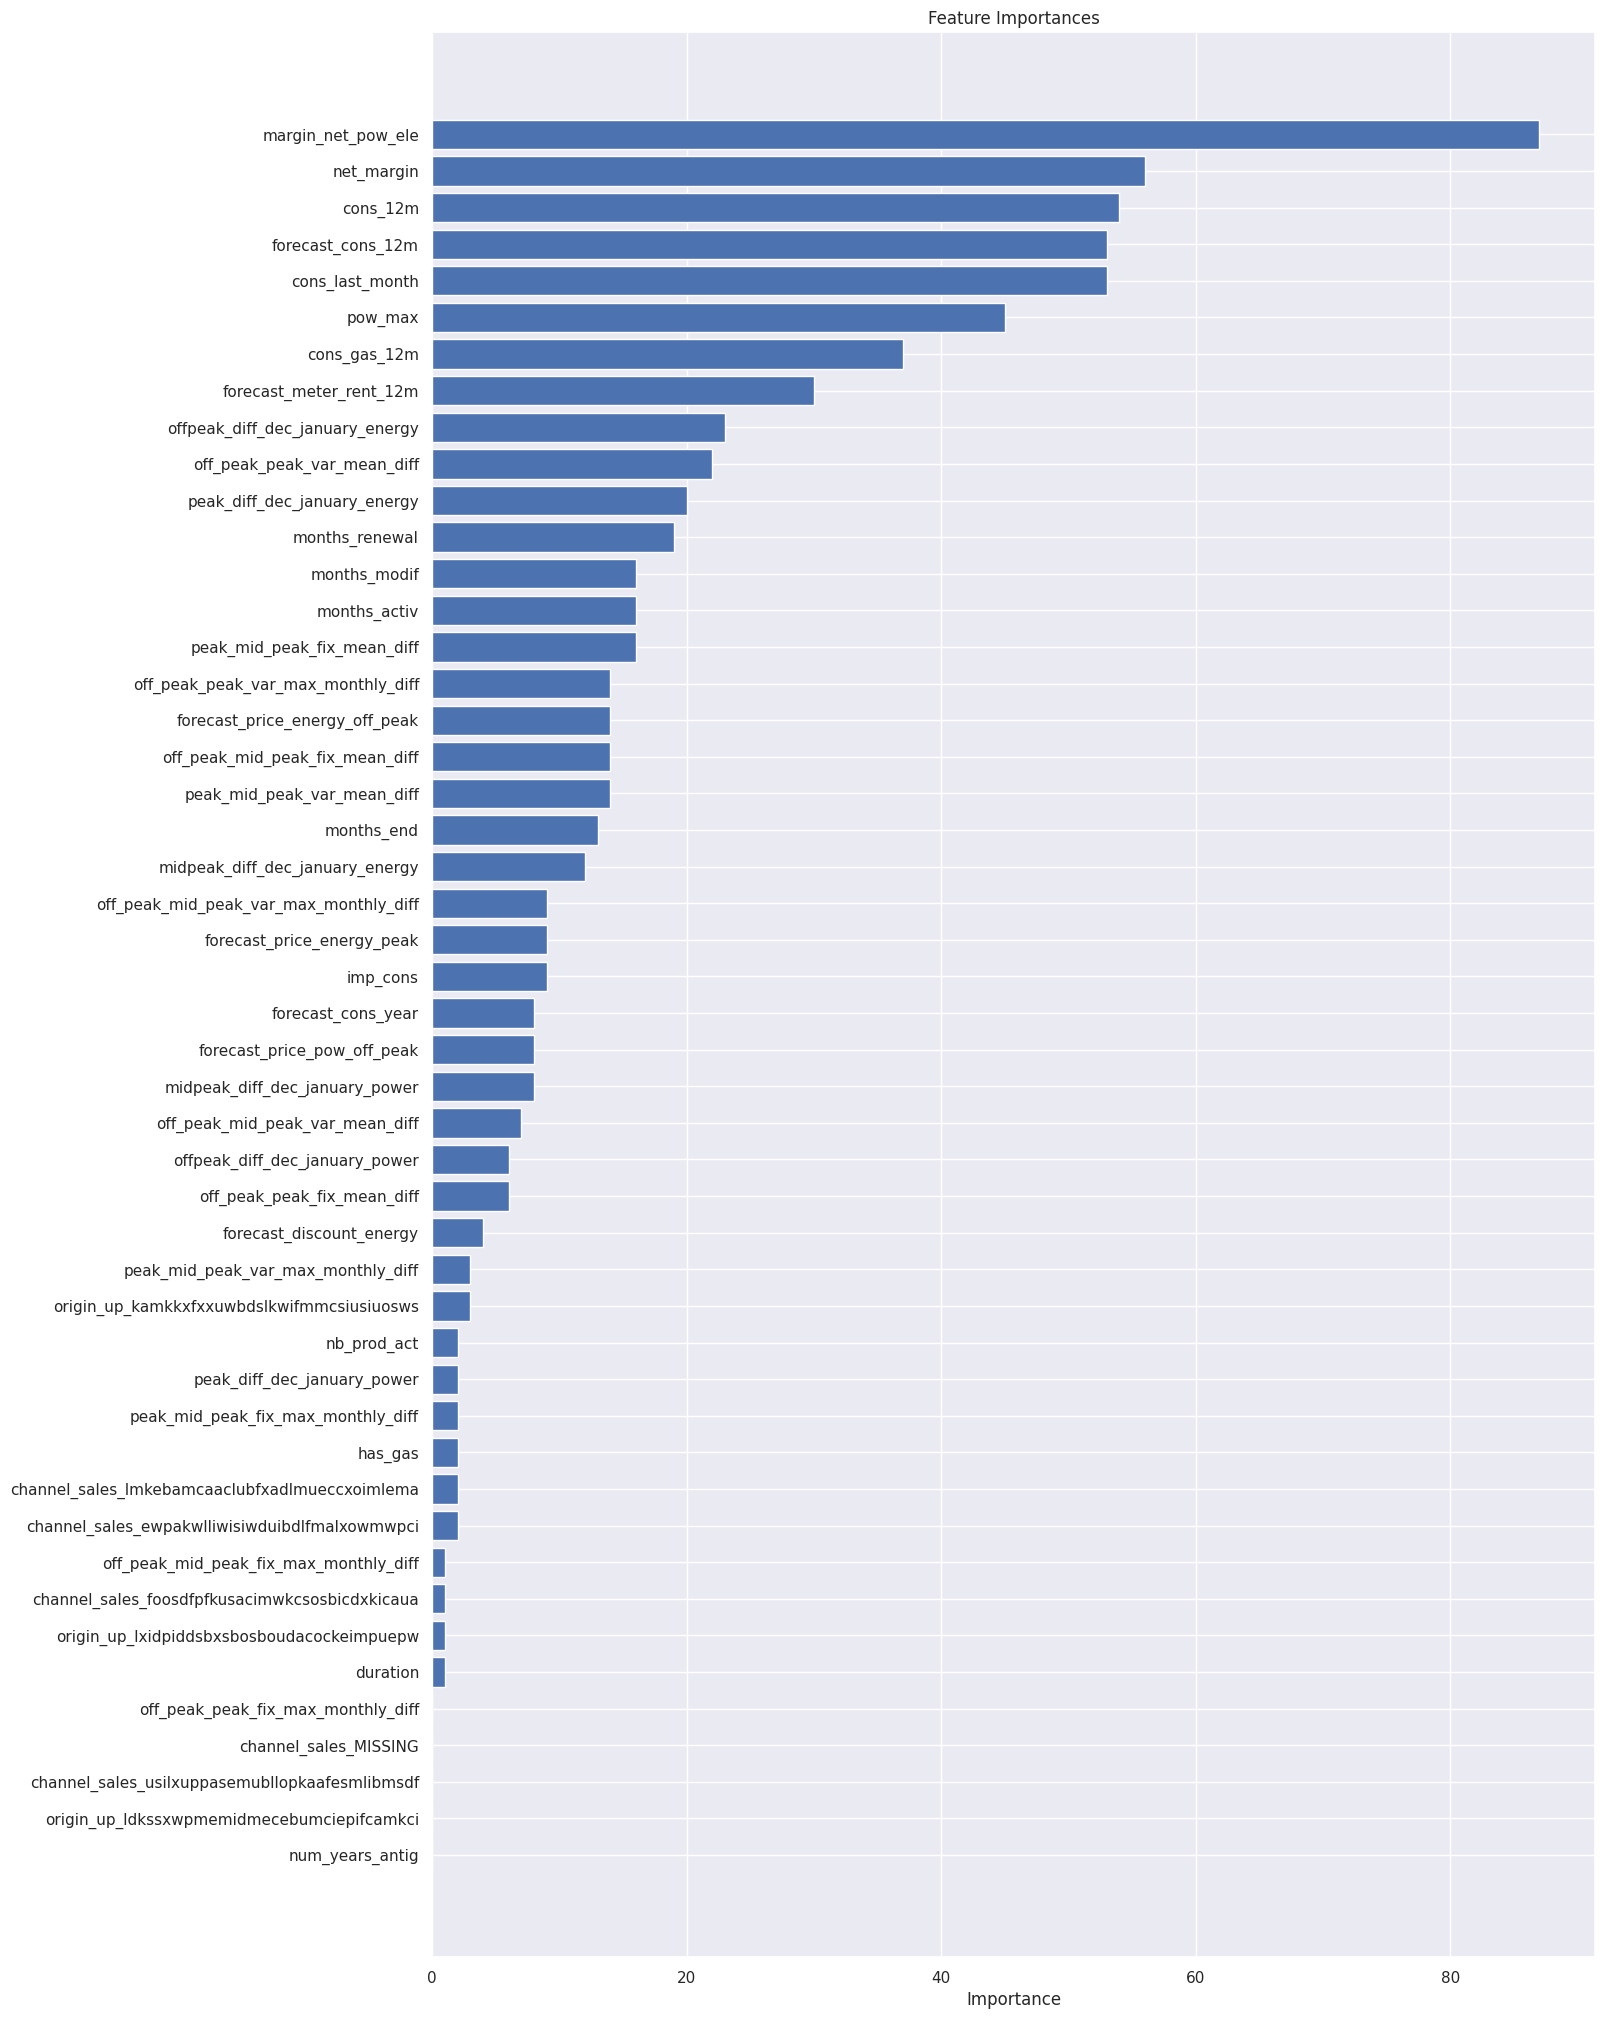

In [386]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

From this chart, we can observe the following points:

- Net margin and consumption over 12 months is a top driver for churn in this model
- Margin on power subscription also is an influential driver
- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract
- The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it
- Our price sensitivity features are scattered around but are not the main driver for a customer churning

The last observation is important because this relates back to our original hypothesis:

    > Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [ ]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [ ]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [ ]:
X_test

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0     4.173390      4.193598         3.165541           3.168368   
1     4.075036      0.000000         3.003461           3.305998   
2     3.848435      0.000000         0.000000           2.756568   
3     4.345433      0.000000         0.000000           3.516690   
4     4.185655      0.000000         3.355834           3.208148   
...        ...           ...              ...                ...   
3647  6.298161      5.541745         5.270979           3.310600   
3648  3.608633      4.009323         2.838219           2.782859   
3649  4.956725      0.000000         3.798374           3.935728   
3650  3.931966      3.509874         2.352183           2.914845   
3651  3.441852      0.000000         0.000000           2.360006   

      forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
0               3.165541                       0.0                 2.073828   
1               3.003461                      30.0                 1.255031   
2               0.000000                       0.0                 1.289366   
3               0.000000                       0.0                 1.304921   
4               3.355834                       0.0                 2.123067   
...                  ...                       ...                      ...   
3647            3.290257                       0.0                 1.300378   
3648            2.838219                       0.0                 1.291591   
3649            3.798374                       0.0                 2.544006   
3650            2.352183                       0.0                 1.288249   
3651            0.000000                       0.0                 1.229938   

      forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                           0.114667                    0.099548   
1                           0.198096                    0.000000   
2                           0.141434                    0.000000   
3                           0.142996                    0.000000   
4                           0.120372                    0.103487   
...                              ...                         ...   
3647                        0.165022                    0.086380   
3648                        0.144038                    0.000000   
3649                        0.101700                    0.092659   
3650                        0.140621                    0.000000   
3651                        0.146694                    0.000000   

      forecast_price_pow_off_peak  ...  peak_mid_peak_fix_mean_diff  \
0                       40.606701  ...                     8.121339   
1                       46.305378  ...                     0.000000   
2                       44.311378  ...                     0.000000   
3                       44.311378  ...                     0.000000   
4                       40.606701  ...                     8.137629   
...                           ...  ...                          ...   
3647                    44.311378  ...                     0.000000   
3648                    45.811378  ...                     0.000000   
3649                    58.995952  ...                    25.760629   
3650                    44.311378  ...                     0.000000   
3651                    44.311378  ...                     0.000000   

      off_peak_mid_peak_fix_mean_diff  off_peak_peak_var_max_monthly_diff  \
0                           24.364021                            0.022138   
1                           45.370636                            0.204604   
2                           44.355820                            0.150211   
3                           44.266930                            0.149902   
4                           24.412893                            0.022225   
...                               ...                                 ...   
3647                        44.

In [ ]:
X_test['churn'] = model.predict(X_test).tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')

Because of how unbalanced the dataset is, the model's performance leaves a lot of room for improvement.